In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as sma
import itertools
import datetime
import matplotlib
import pytest

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt, exp

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

sns.set_style('whitegrid')

import sys
sys.path.append('..')
from src.data.dataset_generator import DatasetGenerator
from src.data.data_transformer import DataTransformer

# 1. Reading in the Data from the API

Download the Data (Montel Data, Weather Data & Entsoe Data)

In [2]:
dg = DatasetGenerator(['all'])
dataset_latest = dg.get_dataset('2018-01-01', 'latest', 'ignored')

The MontelBearer Token seems to be invalid, status 401, 
response: {"Message":"Authorization has been denied for this request."} 
Trying to download updated token now!

Repaired missing entsoe data from dates: ['2021-08-23' '2021-08-24']
Data coverage 100%
Data coverage 100%


# 2. Data Preprocessing

Set datetime as index of the dataframe and display the length and timerange of the downloaded dataset.

In [3]:
# Extract Length, and Timerange of the Downloaded Dataset
X = dataset_latest.Time

datapoints = X.index.max()
date_min = X.min()
date_max = X.max()

print('Number of datapoints in the Dataset: {}'.format(datapoints))
print('Minimum date from data set: {}'.format(date_min))
print('Maximum date from data set: {}'.format(date_max))

# Change Index from Dataframe (new index: Time)
data_hourly = dataset_latest.set_index('Time')
data_hourly.index = pd.date_range(date_min,date_max,freq='H')

Number of datapoints in the Dataset: 31967
Minimum date from data set: 2018-01-01 00:00:00
Maximum date from data set: 2021-08-24 23:00:00


## 2.1 Display Data Characteristics

In [4]:
data_hourly

,SPOTPrice,Load,Solar,Wind Offshore,Wind Onshore,temp_muc,dwpt_muc,rhum_muc,prcp_muc,wspd_muc,pres_muc,tsun_muc,temp_ham,dwpt_ham,rhum_ham,prcp_ham,wspd_ham,pres_ham,tsun_ham
2018-01-01 00:00:00,-5.27,51511.00,0.0,2917.50,29575.00,5.5,1.2,74.0,0.0,10.4,1009.5,0.0,8.2,7.8,97.0,0.3,13.0,993.8,0.0
2018-01-01 01:00:00,-29.99,50191.25,0.0,2999.25,30938.25,7.9,0.6,60.0,0.0,14.0,1008.9,0.0,8.7,7.6,93.0,0.1,19.4,993.3,0.0
2018-01-01 02:00:00,-56.65,48959.50,0.0,3096.00,31699.25,7.8,0.7,61.0,0.0,13.3,1008.7,0.0,8.3,6.4,88.0,0.0,24.8,994.1,0.0
2018-01-01 03:00:00,-63.14,47927.00,0.0,3136.75,32333.00,7.9,1.5,64.0,0.0,14.8,1009.1,0.0,8.1,6.4,89.0,0.0,22.7,993.9,0.0
2018-01-01 04:00:00,-64.62,47790.00,0.0,3212.00,31982.25,8.3,2.9,69.0,0.0,16.6,1010.1,0.0,8.1,5.9,86.0,0.0,24.1,993.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-24 19:00:00,122.41,49898.50,13087.5,1879.50,7108.00,15.9,11.7,76.0,0.2,9.3,1022.8,0.0,20.4,9.6,50.0,0.0,11.1,1029.2,0.0
2021-08-24 20:00:00,119.24,49898.50,13087.5,1879.50,7108.00,15.9,11.7,76.0,0.2,9.3,1022.8,0.0,20.4,9.6,50.0,0.0,11.1,1029.2,0.0
2021-08-24 21:00:00,106.27,49898.50,13087.5,1879.50,7108.00,15.9,11.7,76.0,0.2,9.3,1022.8,0.0,20.4,9.6,50.0,0.0,11.1,1029.2,0.0
2021-08-24 22:00:00,100.00,49898.50,13087.5,1879.50,7108.00,15.9,11.7,76.0,0.2,9.3,1022.8,0.0,20.4,9.6,50.0,0.0,11.1,1029.2,0.0


In [5]:
data_hourly.describe()

,SPOTPrice,Load,Solar,Wind Offshore,Wind Onshore,temp_muc,dwpt_muc,rhum_muc,prcp_muc,wspd_muc,pres_muc,tsun_muc,temp_ham,dwpt_ham,rhum_ham,prcp_ham,wspd_ham,pres_ham,tsun_ham
count,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000,31968.000000
mean,41.922011,58534.524509,5186.285410,2632.163664,10995.118838,11.015490,5.183871,70.638670,0.115750,10.060720,1016.898092,14.590246,10.611752,6.112090,76.271177,0.075272,14.765397,1014.852402,12.531594
std,21.288540,10990.127324,7801.384027,1816.769187,8693.835140,8.259904,6.689036,18.740989,0.721565,5.695112,8.598775,23.392737,7.459336,6.098724,16.856973,0.448636,7.847857,10.165871,21.724818
min,-80.690000,0.000000,0.000000,0.000000,0.000000,-13.400000,-17.500000,15.000000,0.000000,0.400000,982.000000,0.000000,-13.800000,-18.100000,18.000000,0.000000,0.000000,978.000000,0.000000
25%,30.100000,49919.687500,0.000000,970.250000,4313.000000,4.500000,-0.100000,57.000000,0.000000,6.100000,1012.000000,0.000000,5.100000,1.700000,66.000000,0.000000,9.000000,1008.700000,0.000000
50%,40.770000,58095.500000,214.125000,2449.375000,8406.000000,10.900000,4.900000,74.000000,0.000000,8.600000,1017.000000,0.000000,10.100000,6.300000,80.000000,0.000000,13.700000,1015.600000,0.000000
75%,52.440000,66945.187500,8569.062500,4114.500000,15403.375000,17.100000,11.200000,87.000000,0.000000,12.200000,1021.800000,28.000000,15.925000,10.800000,90.000000,0.000000,19.400000,1021.400000,17.000000
max,200.040000,90809.500000,36175.250000,7126.250000,40987.250000,34.800000,20.300000,100.000000,37.500000,49.000000,1047.100000,60.000000,35.000000,21.600000,100.000000,38.700000,60.100000,1046.200000,60.000000


## 2.3 Extract Features from the Dataframe

Extract endogenous and exogenous features from the dataset:
* Endogenous Dataset: SPOTPrice
* First Exogenous Dataset: All features except the SPOTPrice
* Second Exogenous Dataset: The Entsoe Data (Load, Wind, Solar)
* Third Exogenous Dataset: The Meteostat Data
* Fourth Exogenous Dataset: The Meteostat Data from Munich
* Fifth Exogenous Dataset: The Meteostat Data from Hamburg

In [6]:
# Endogenous Data
data_spot = data_hourly.SPOTPrice
# 1. Exogenous Data
data_ex1 = data_hourly.iloc[:,1:]
# 2. Exogenous Data
data_ex2 = data_hourly.iloc[:,1:5]
# 3. Exogenous Data
data_ex3 = data_hourly.iloc[:,5:]
# 4. Exogenous Data
data_ex4 = data_hourly.iloc[:,5:12]
# 5. Exogenous Data
data_ex5 = data_hourly.iloc[:,12:]

Each Feature of the Dataframe is extracted as Pandas Series

In [7]:
data_load = data_hourly.Load
data_solar = data_hourly.Solar
data_wind_off = data_hourly["Wind Offshore"]
data_wind_on = data_hourly["Wind Onshore"]
data_temp = data_hourly.temp_muc
data_dwpt = data_hourly.dwpt_muc
data_rhum = data_hourly.rhum_muc
data_prcp = data_hourly.prcp_muc
data_wspd = data_hourly.wspd_muc
data_pres = data_hourly.pres_muc
data_tsun = data_hourly.tsun_muc

## 2.4 Create Spotprice Datasets with different length (Final Week excluded)

For testing univariant spot price forecasting, subdivide the whole dataset into datasets with the following lengths \
(final week is excluded for the model evaluation; will be changed for a better quality in evaluation):
* previous 3, 2 and 1 year/-s
* previous 6, 3 and 1 month/-s
* previous 3, 2 and 1 week/-s
* previous 5, 4, 3, 2 and 1 day/-s

In [8]:
# Training and Validation Sets for Model Training and Hyperparameter Tuning

df_all = data_spot.iloc[:-168]
df_ex1_all = data_ex1.iloc[:-168,:]
df_ex2_all = data_ex2.iloc[:-168,:]
df_ex3_all = data_ex3.iloc[:-168,:]
df_ex4_all = data_ex4.iloc[:-168,:]
df_ex5_all = data_ex5.iloc[:-168,:]

df_3a = data_spot.iloc[-26472:-168]
df_ex1_3a = data_ex1.iloc[-26472:-168,:]
df_ex2_3a = data_ex2.iloc[-26472:-168,:]
df_ex3_3a = data_ex3.iloc[-26472:-168,:]
df_ex4_3a = data_ex4.iloc[-26472:-168,:]
df_ex5_3a = data_ex5.iloc[-26472:-168,:]

df_2a = data_spot.iloc[-17712:-168]
df_ex1_2a = data_ex1.iloc[-17712:-168,:]
df_ex2_2a = data_ex2.iloc[-17712:-168,:]
df_ex3_2a = data_ex3.iloc[-17712:-168,:]
df_ex4_2a = data_ex4.iloc[-17712:-168,:]
df_ex5_2a = data_ex5.iloc[-17712:-168,:]

df_1a = data_spot.iloc[-8928:-168]
df_ex1_1a = data_ex1.iloc[-8928:-168,:]
df_ex2_1a = data_ex2.iloc[-8928:-168,:]
df_ex3_1a = data_ex3.iloc[-8928:-168,:]
df_ex4_1a = data_ex4.iloc[-8928:-168,:]
df_ex5_1a = data_ex5.iloc[-8928:-168,:]

df_6m = data_spot.iloc[-4512:-168]
df_ex1_6m = data_ex1.iloc[-4512:-168,:]
df_ex2_6m = data_ex2.iloc[-4512:-168,:]
df_ex3_6m = data_ex3.iloc[-4512:-168,:]
df_ex4_6m = data_ex4.iloc[-4512:-168,:]
df_ex5_6m = data_ex5.iloc[-4512:-168,:]

df_3m = data_spot.iloc[-2304:-168]
df_ex1_3m = data_ex1.iloc[-2304:-168,:]
df_ex2_3m = data_ex2.iloc[-2304:-168,:]
df_ex3_3m = data_ex3.iloc[-2304:-168,:]
df_ex4_3m = data_ex4.iloc[-2304:-168,:]
df_ex5_3m = data_ex5.iloc[-2304:-168,:]

df_1m = data_spot.iloc[-912:-168]
df_ex1_1m = data_ex1.iloc[-912:-168,:]
df_ex2_1m = data_ex2.iloc[-912:-168,:]
df_ex3_1m = data_ex3.iloc[-912:-168,:]
df_ex4_1m = data_ex4.iloc[-912:-168,:]
df_ex5_1m = data_ex5.iloc[-912:-168,:]

df_3w = data_spot.iloc[-672:-168]
df_ex1_3w = data_ex1.iloc[-672:-168,:]
df_ex2_3w = data_ex2.iloc[-672:-168,:]
df_ex3_3w = data_ex3.iloc[-672:-168,:]
df_ex4_3w = data_ex4.iloc[-672:-168,:]
df_ex5_3w = data_ex5.iloc[-672:-168,:]

df_2w = data_spot.iloc[-504:-168]
df_ex1_2w = data_ex1.iloc[-504:-168,:]
df_ex2_2w = data_ex2.iloc[-504:-168,:]
df_ex3_2w = data_ex3.iloc[-504:-168,:]
df_ex4_2w = data_ex4.iloc[-504:-168,:]
df_ex5_2w = data_ex5.iloc[-504:-168,:]

df_1w = data_spot.iloc[-336:-168]
df_ex1_1w = data_ex1.iloc[-336:-168,:]
df_ex2_1w = data_ex2.iloc[-336:-168,:]
df_ex3_1w = data_ex3.iloc[-336:-168,:]
df_ex4_1w = data_ex4.iloc[-336:-168,:]
df_ex5_1w = data_ex5.iloc[-336:-168,:]

df_5d = data_spot.iloc[-288:-168]
df_ex1_5d = data_ex1.iloc[-288:-168,:]
df_ex2_5d = data_ex2.iloc[-288:-168,:]
df_ex3_5d = data_ex3.iloc[-288:-168,:]
df_ex4_5d = data_ex4.iloc[-288:-168,:]
df_ex5_5d = data_ex5.iloc[-288:-168,:]

df_4d = data_spot.iloc[-264:-168]
df_ex1_4d = data_ex1.iloc[-264:-168,:]
df_ex2_4d = data_ex2.iloc[-264:-168,:]
df_ex3_4d = data_ex3.iloc[-264:-168,:]
df_ex4_4d = data_ex4.iloc[-264:-168,:]
df_ex5_4d = data_ex5.iloc[-264:-168,:]

df_3d = data_spot.iloc[-240:-168]
df_ex1_3d = data_ex1.iloc[-240:-168,:]
df_ex2_3d = data_ex2.iloc[-240:-168,:]
df_ex3_3d = data_ex3.iloc[-240:-168,:]
df_ex4_3d = data_ex4.iloc[-240:-168,:]
df_ex5_3d = data_ex5.iloc[-240:-168,:]

df_2d = data_spot.iloc[-216:-168]
df_ex1_2d = data_ex1.iloc[-216:-168,:]
df_ex2_2d = data_ex2.iloc[-216:-168,:]
df_ex3_2d = data_ex3.iloc[-216:-168,:]
df_ex4_2d = data_ex4.iloc[-216:-168,:]
df_ex5_2d = data_ex5.iloc[-216:-168,:]

df_1d = data_spot.iloc[-192:-168]
df_ex1_1d = data_ex1.iloc[-192:-168,:]
df_ex2_1d = data_ex2.iloc[-192:-168,:]
df_ex3_1d = data_ex3.iloc[-192:-168,:]
df_ex4_1d = data_ex4.iloc[-192:-168,:]
df_ex5_1d = data_ex5.iloc[-192:-168,:]

# 3. Baseline Models

## 3.1 Scoring Metrics

For model hyperparameter tuning the RMSE metric is used \
For the evaluation of the model, four metric are taken into account:
* root mean squared error (RMSE) --> Metric = rmse
* mean absolute error (MAE) --> Metric = mean_absolute_error
* mean absolute percentage error (MAPE) --> Metric = mape
* symmetric mean absolute percentage error (sMAPE) --> Metric = smape

In [9]:
def mape(y_true, y_pred):
    mape_score = abs((y_true-y_pred)/y_true)*100
    return np.mean(mape_score)
def smape(y_true, y_pred):
    smape_score = 200*abs((y_pred-y_true)/(y_true+y_pred))
    return np.mean(smape_score)
def rmse(y_true, y_pred):
    rmse_score = mean_squared_error(y_true,y_pred)
    return np.sqrt(rmse_score)

In the section below, the final datetime for the training set can be determined. For testing purposes, this was used as the final training value, in order to test the functionality for the baseline models. 

In [12]:
# Final Date for Training Set (Format: YEAR-MONTH-DAY XX:YY:ZZ)
# Prediction from this Timestamp: +1h; +24h; +168h
split_date = pd.Timestamp('2021-07-25 16:00:00')

## 3.1. Naive

This is the simplest model for prediction and used as a baseline model. This model uses the latest datavalue for all the following prediction values.

### 3.1.1 Naive Function for Visualisation

In [13]:
def vis_naive_model(data, pred_ind, metric):
    """
    Naive model forecasting for visualization purposes
    Every future prediction value is set to the latest value in the training set
    The final datetime value determines the end of the training set
    
    :param data: pandas series or dataframe of the spotprice data
    :param pred_ind: latest datetime (format: YYYY-MM-DD HH:MM:SS) in training set
    :return pred_naive: pandas series containing prediciton values
    """
    
    # check if data contains pred_ind (pred_ind = date)
    if (pred_ind not in data.index):
        raise ValueError('Please ensure that the Dataframe contains the Start Prediction Index.')

    # prepare prediciton indexes
    start = len(data.loc[:pred_ind])
    dti = data.index[start:]
    
    # pandas series with every prediction value set to latest training set value
    pred_naive = pd.Series(data=data.loc[pred_ind], index=dti)

    # scoring
    score = metric(pred_naive.values, data[start:].values)
    
    # plot input data and prediction values
    plt.figure(figsize=[17,10])
    plt.plot(data.loc[pred_ind:], 'b', label='Data')
    plt.plot(pred_naive.index, pred_naive, 'r', label='Prediction')
    plt.tick_params(axis='x',labelsize=30)
    plt.tick_params(axis='y',labelsize=30)
    plt.xticks(rotation=30)
    plt.xlabel('Time', fontsize=30)
    plt.ylabel('Spot Price [€/MWh]', fontsize=30)
    plt.title('NAIVE: Data vs. Prediction', fontsize=40)
    plt.legend(fontsize=30)
    
    return pred_naive, score

Metric Score:	39.32687814483112


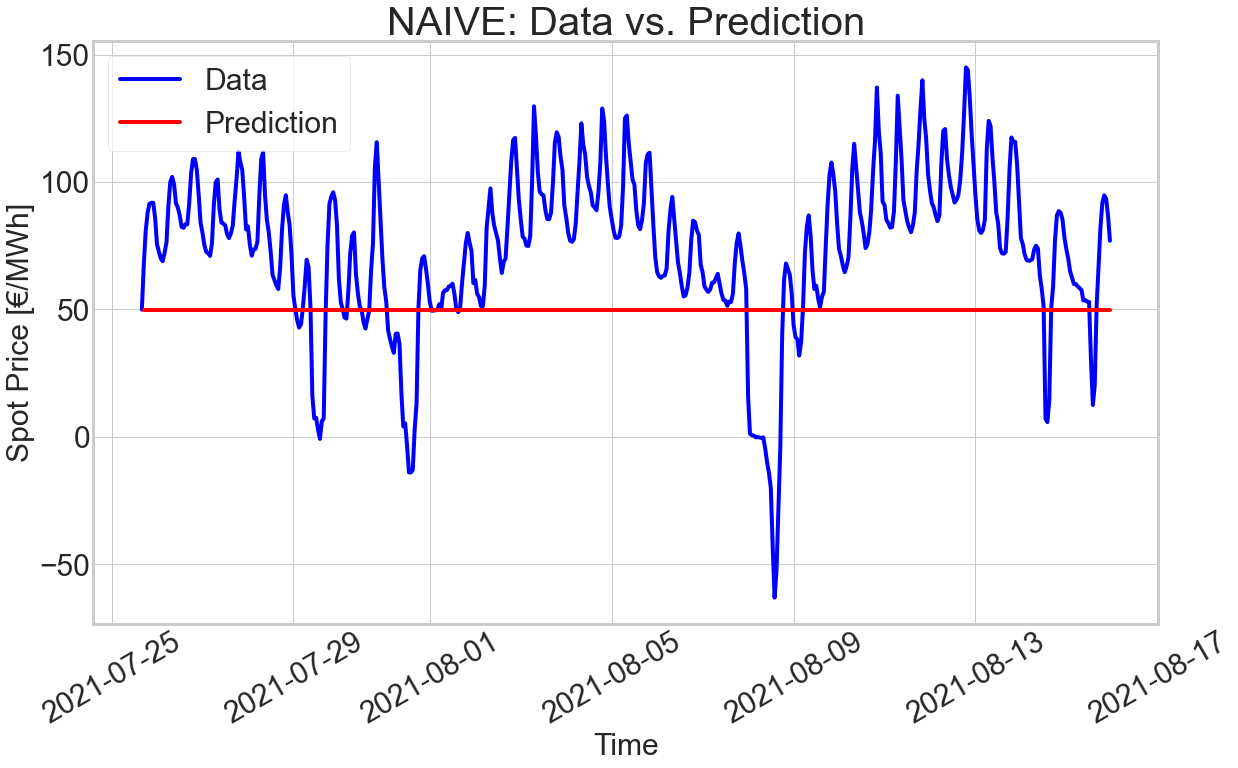

In [37]:
vis_naive, score_naive = vis_naive_model(df_1m,split_date, rmse)
print(f'Metric Score:\t{score_naive}')

### 3.1.2 Naive Function for Final Usage

To do: Add Metric

In [14]:
def naive_model(data, pred_ind):
    """
    Naive model forecasting for +1h, +24h, +168h
    All three future prediction values are set to the latest value in the training set
    The final datetime value determines the end of the training set
    
    :param data: pandas series or dataframe of the spotprice data
    :param pred_ind: latest datetime (format: YYYY-MM-DD HH:MM:SS) in training set
    :return pred_naive: pandas series containing all three prediciton values
    """
    
    # check if data contains pred_ind (pred_ind = date)
    if (pred_ind not in data.index):
        raise ValueError('Please ensure that the Dataframe contains the Start Prediction Index.')

    # prepare prediction indexes
    n_idx = len(data.loc[:pred_ind])
    dt = data.index
    dti = pd.to_datetime([dt[n_idx],dt[n_idx+23],dt[n_idx+167]])
    
    # pandas series containing all three prediction values with latest value in training set
    pred_naive = pd.Series(data=data.loc[pred_ind], index=dti)
    
    return pred_naive

In [26]:
naive = naive_model(df_1m,split_date)
print(naive)

2021-07-25 17:00:00    49.91
2021-07-26 16:00:00    49.91
2021-08-01 16:00:00    49.91
dtype: float64


## 3.2 SNaive

Another simple baseline model, which predicts the datepoints of interest with the data from the previous year (seasonality). \
As it can be seen in the plot below, the performance of this model is very poor. This model uses the spot price values from the previous year. In order to improve the performance, a bias from the trend difference of both years can be added. This should eliminate the offset between the real data and the prediction. 

### 3.2.1 SNaive Function for Visualisation

In [15]:
def vis_snaive_model(data, pred_ind, metric):
    """
    SNaive model forecasting for visualization purposes
    Every future prediction value is set to the latest value of the previous seasonality in the training set
    The final datetime value determines the end of the train set
    
    :param data: pandas series or dataframe of the spotprice data
    :param pred_ind: latest datetime (format: YYYY-MM-DD HH:MM:SS) in training set
    :return pred_naive: pandas series containing prediciton values
    """
    
    # indexes for getting the values of the previous seasonality (here: previous year)
    date_1a_start = pred_ind - datetime.timedelta(days=365,hours=-1)
    date_1a_end = data.index[-1] - datetime.timedelta(days=365)
    
    # check if data contains pred_ind (pred_ind = date)
    if (pred_ind not in data.index):
        raise ValueError('Please ensure that the Dataframe contains the Start Prediction Index.')
    
    # checking if data from previous seasonality is available in the dataset
    elif (date_1a_start not in data.index):
        raise ValueError('Please ensure that the Dataframe contains Data from at least one Year ago.')
    
    # prepare prediction indexes
    n_idx = len(data.loc[:pred_ind])
    dti = data.index[n_idx:]
    
    # get the values of the previous seasonality
    da = data[date_1a_start:date_1a_end].values
    
    # pandas series containing all prediction values
    pred_snaive = pd.Series(data=da, index=dti)
    
    # scoring
    score = metric(pred_snaive.values, data[n_idx:].values)
    
    # plot input data and prediction values
    plt.figure(figsize=[17,10])
    plt.plot(data.loc[pred_ind:], 'b', label='Data')
    plt.plot(pred_snaive.index, pred_snaive, 'r', label='Prediction')
    plt.tick_params(axis='x',labelsize=30)
    plt.tick_params(axis='y',labelsize=30)
    plt.xticks(rotation=30)
    plt.xlabel('Time', fontsize=30)
    plt.ylabel('Spot Price [€/MWh]', fontsize=30)
    plt.title('SNAIVE: Data vs. Prediction', fontsize=40)
    plt.legend(fontsize=30)
    
    return pred_snaive, score

Metric Score:	51.18767354639178


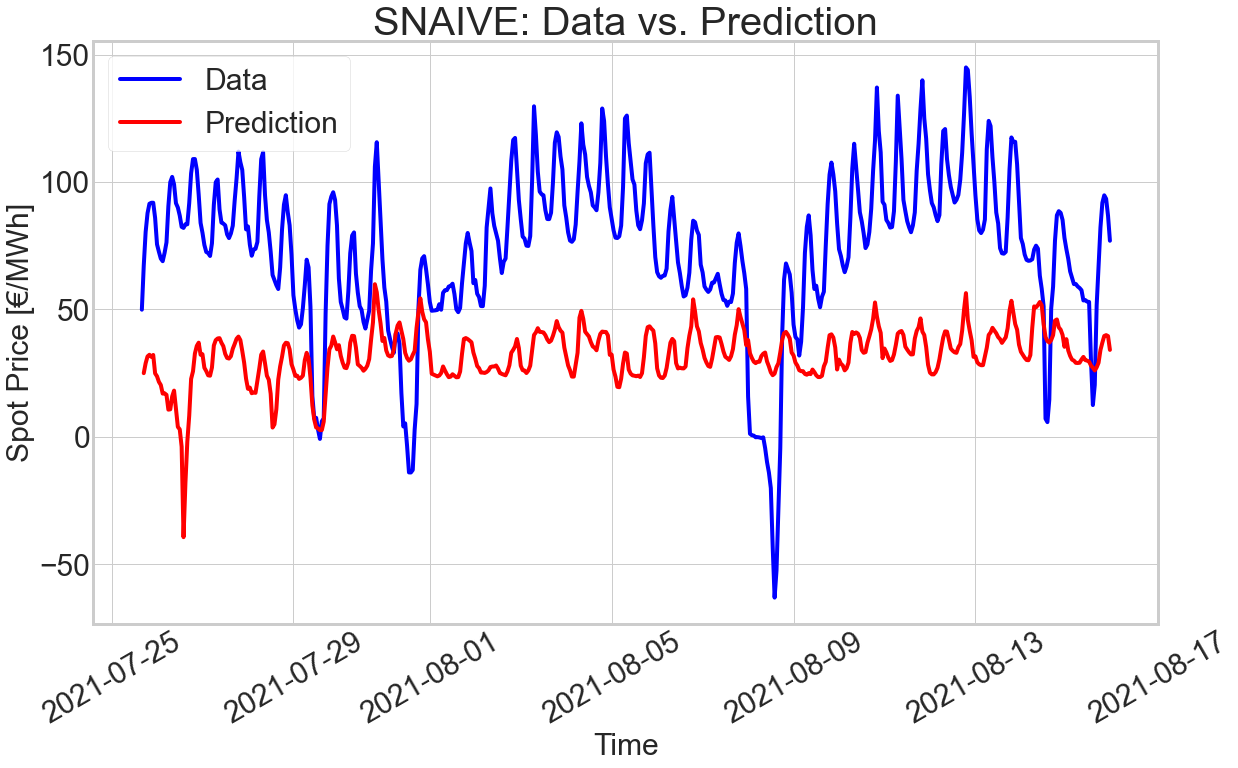

In [45]:
vis_snaive, score_snaive = vis_snaive_model(df_2a,split_date, rmse)
print(f'Metric Score:\t{score_snaive}')

### 3.2.2 SNaive Function for Final Usage

To do: Add Metric

In [16]:
def snaive_model(data, pred_ind):
    """
    SNaive model forecasting for visualization purposes
    Every future prediction value is set to the latest value of the previous seasonality in the training set
    The final datetime value determines the end of the train set
    
    :param data: pandas series or dataframe of the spotprice data
    :param pred_ind: latest datetime (format: YYYY-MM-DD HH:MM:SS) in training set
    :return pred_naive: pandas series containing prediciton values
    """
    
    # index for getting the values of the previous seasonality (here: previous year)
    date_1a = pred_ind - datetime.timedelta(days=365)
    
    # check if data contains pred_ind (pred_ind = date)
    if (pred_ind not in data.index):
        raise ValueError('Please ensure that the Dataframe contains the Start Prediction Index.')
    # checking if data from previous seasonality is available in the dataset
    elif (date_1a not in data.index):
        raise ValueError('Please ensure that the Dataframe contains Data from at least one Year ago.')
    
    # prepare prediction indexes
    n_idx = len(data.loc[:pred_ind])
    dt = data.index
    dti = pd.to_datetime([dt[n_idx],dt[n_idx+23],dt[n_idx+167]])
    
    # get predicition values from previous seasonality
    data = np.array([data.loc[date_1a+datetime.timedelta(hours=1)],data.loc[date_1a+datetime.timedelta(hours=24)],
                    data.loc[date_1a+datetime.timedelta(hours=168)]])
    
    # pandas series containing all three prediction values
    pred_snaive = pd.Series(data=data, index=dti)
    
    return pred_snaive

In [48]:
snaive = snaive_model(df_2a,split_date)
print(snaive)

2021-07-25 17:00:00    25.01
2021-07-26 16:00:00    -1.82
2021-08-01 16:00:00    25.65
dtype: float64


# 4. Valdiation and Evaluation Methods

## 4.1 Rolling Forecast (For Validation)

Rolling Forecast with an example gap of `gap=3`
* blue = train set
* red = validation set

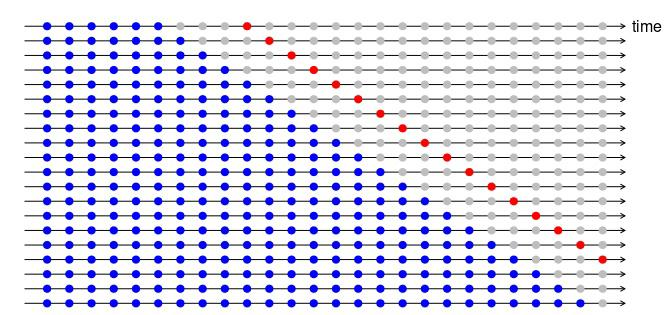

Rolling Foreccast with no gap

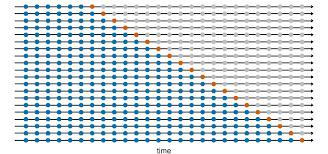

In [10]:
def rolling_forecast(data,min_train,gap):
    """
    Splitting the dataset with a rolling forecast validation method
    The first iteration returns a training dataset with min_train length and one validation set of length one
    After each iteration the training set is increased by the size of one sample
    Between the training set and the validation set is a gap for skipped values
    (+1h: gap=0; +24h: gap=23; +168h: gap = 167)
    
    :param data: pandas series or dataframe of the training and validation spotprice data
    :param min_train: length of the dataset for the first iteration
    :param gap: skipped values between training and validation set
    :yield split_train:
    :yield split_val:
    """
    
    for i in range(len(data)-min_train-gap):
        split_train = data[:min_train+i]
        split_val = data[min_train+i+gap:min_train+i+gap+1]
        yield split_train, split_val

In [11]:
def rolling_forecast_ex(data,ex_data,min_train,gap):
    """
    Splitting the dataset with a rolling forecast validation method
    The first iteration returns a training dataset with min_train length and one validation set of length one
    After each iteration the training set is increased by the size of one sample
    Between the training set and the validation set is a gap for skipped values
    (+1h: gap=0; +24h: gap=23; +168h: gap = 167)
    
    :param data: pandas series or dataframe of the training and validation spotprice data (endogenous data)
    :param ex_data: pandas series or dataframe of the exogenous data
    :param min_train: length of the dataset for the first iteration
    :param gap: skipped values between training and validation set
    :yield split_ex: 
    :yield split_train:
    :yield split_val:
    """
    
    for i in range(len(data)-min_train-gap):
        split_ex = ex_data[:min_train+i]
        split_train = data[:min_train+i]
        split_val = data[min_train+i+gap:min_train+i+gap+1]
        yield split_ex, split_train, split_val

For the project, there are three gaps of interest. Predicting +1h, +24 and +168h. Therefore we determine our min_train_size for cross validation. For Prediction of +1h, set `gap=0`; for prediction of +24h, set `gap=23`; for prediction of +168h set `gap=167`.

In [73]:
rolling_1h = rolling_forecast_ex(df_1d,ex_data=df_ex2_1d, min_train=10, gap=0)

In [75]:
# Example for plotting the rolling forward method:
# i=0
# for cv_ex,cv_train,cv_val in rolling_1h:
#     print(f'CV[{i+1}]')
#     print(f'Train:\t{cv_train}')
#     print(f'Exogenous:\t{cv_ex}')
#     print(f'Val:\t{cv_val}')
#     print('------')
#     i+=1

In [13]:
rolling_24h = rolling_forecast(df_5d,50,gap=23)

In [15]:
rolling_168h = rolling_forecast(df_2w,150,gap=167)

## 4.2 Sliding Window (For Evaluation)

For the project, there are three gaps of interest. Predicting +1h, +24 and +168h. Therefore we determine our min_train_size for cross validation. For Prediction of +1h, set `gap=0`; for prediction of +24h, set `gap=23`; for prediction of +168h set `gap=167`.

Sliding Window with not gap:
* black: training set
* pink: test set

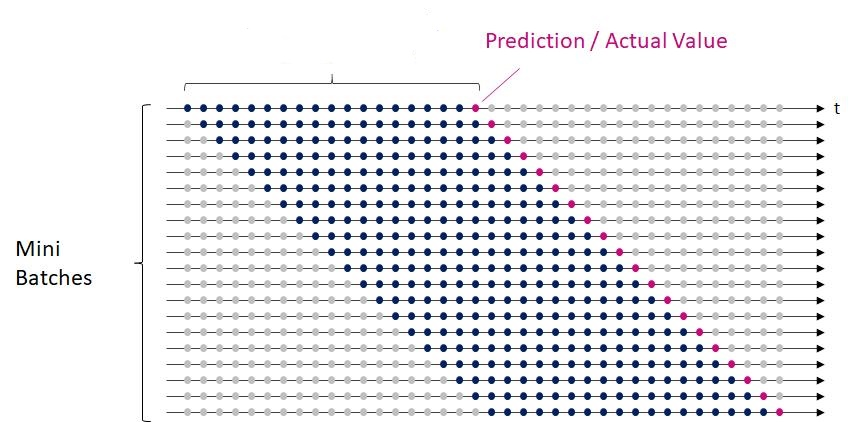

In [12]:
def sliding_window(data,window_size,gap):
    """
    Splitting the dataset with a sliding window evaluation method
    As a queue the training set and validation value are moving on one position after each iteration
    Between the training set and the validation set is a gap for skipped values
    (+1h: gap=0; +24h: gap=23; +168h: gap = 167)
    
    :param data: pandas series or dataframe for the training and validation spotprice data
    :param window_size: length of the training size
    :param gap: skipped values between training and validation set
    :yield split_train:
    :yield split_val:
    """
    
    for i in range(len(data)-window_size-gap):
        split_train = data[i:window_size+i]
        split_val = data[i+window_size+gap:i+window_size+gap+1]
        yield split_train, split_val

In [13]:
def sliding_window_ex(data,ex_data,window_size,gap):
    """
    Splitting the dataset with a sliding window evaluation method
    As a queue the training set and validation value are moving on one position after each iteration
    Between the training set and the validation set is a gap for skipped values
    (+1h: gap=0; +24h: gap=23; +168h: gap = 167)
    
    :param data: pandas series or dataframe for the training and validation spotprice data
    :param ex_data: pandas series or dataframe of the exogenous data
    :param window_size: length of the training size
    :param gap: skipped values between training and validation set
    :yield split_ex:
    :yield split_train:
    :yield split_val:
    """
    
    for i in range(len(data)-window_size-gap):
        split_ex = ex_data[i:window_size+i]
        split_train = data[i:window_size+i]
        split_val = data[i+window_size+gap:i+window_size+gap+1]
        yield split_ex, split_train, split_val

# 5. SARIMAX Model

## 5.1 Cross Validation Score

In [14]:
def sarimax_cross_validation_score(cv,gap,metric,par,seas_par):
    """
    Cross validation score for the SARIMAX model
    
    :param cv: cross validation method (here: rolling_forecast)
    :param metric: metric used for hyperparameter tuning and validation (RMSE; MAE; MAPE; sMAPE)
    :param par: tuple of parameter for the SARIMAX model in format (p,d,q)
    :param seas_par: tuple of seasonal parameter for the SARIMAX model in format (P,D,Q,S)
    :return cv_scores: returns a numpy array of the cross validation score for each iteration
    :return train_len: returns a numpy array of the train dataset length for each iteratiomn
    """
    
    cv_scores=[]
    train_len = []
    for cv_train,cv_val in cv:
        model = SARIMAX(cv_train,order=par,seasonal_order=seas_par)
        model_fit = model.fit(method='powell',disp=False)
        preds = model_fit.predict(len(cv_train)+gap,len(cv_train)+gap)
        score = metric(y_true=cv_val, y_pred=preds)
        cv_scores.append(score)
        train_len.append(len(cv_train)-1)
    return np.array(cv_scores), np.array(train_len)

In [15]:
def sarimax_cross_validation_score_exog(cv,gap,metric,par,seas_par):
    """
    Cross validation score for the SARIMAX model
    
    :param cv: cross validation method (here: rolling_forecast)
    :param metric: metric used for hyperparameter tuning and validation (RMSE; MAE; MAPE; sMAPE)
    :param par: tuple of parameter for the SARIMAX model in format (p,d,q)
    :param seas_par: tuple of seasonal parameter for the SARIMAX model in format (P,D,Q,S)
    :return cv_scores: returns a numpy array of the cross validation score for each iteration
    :return train_len: returns a numpy array of the train dataset length for each iteratiomn
    """
    
    cv_scores=[]
    train_len = []
    for cv_ex,cv_train,cv_val in cv:
        model = SARIMAX(cv_train,exog=cv_ex,order=par,seasonal_order=seas_par)
        model_fit = model.fit(method='powell',disp=False)
        preds = model_fit.get_predict(len(cv_train)+gap,len(cv_train)+gap)
        score = metric(y_true=cv_val, y_pred=preds)
        cv_scores.append(score)
        train_len.append(len(cv_train)-1)
    return np.array(cv_scores), np.array(train_len)

## 5.2 Hyperparameter Tuning 
#### Perform a GridSearch Tuning the Hyperparameter; Evaluate best Scoring to determine TimeWindow & Model Parameters

In [16]:
import warnings
warnings.filterwarnings('ignore')

Hyperparameters for the SARIMAX Model:
* SARIMAX Model Parameter: (p,d,q)
* SARIMAX Model Sesonal Parameter: (P,D,Q,S)
* Length of the Training Data

In [17]:
def grid_search(data,ex_data,min_train,gap,metric,p_max,d_max,q_max):
    """
    Hyperparameter Tuning for the SARIMAX model
    
    :param data: pandas series or dataframe of the spotprice data (endogenous data)
    :param ex_data: pandas series or dataframe of the exogenous data (if not needed ex_data=None)
    :param min_train: length of the dataset for the first iteration
    :param gap:skipped values between training and validation set
    :param metric: metric used for hyperparameter tuning and validation (RMSE; MAE; MAPE; sMAPE)
    :param p_max: maximum p value (p-1) of the tuple (p,d,q) and (P,D,Q,S) --> recommended p_max = 3
    :param q_max: maximum q value (q-1) of the tuple (p,d,q) and (P,D,Q,S) --> recommended d_max = 3
    :param d_max: maximum d value (d-1) of the tuple (p,d,q) and (P,D,Q,S) --> recommended q_max = 2
    :return df: returns dataframe after hyperparemter tuning
    :return df_rank: returns ranked dataframe (depending on the scoring)
    """
    
    p = range(0,p_max)
    d = range(0,d_max)
    q = range(0,q_max)
    s = range(24,25)
    
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(p, d, q, s))
    
    columns = ['Parameter','SeasonalParameter','MeanScore','TrainLength',' MinScore',]
    df = pd.DataFrame(columns=columns)
    
    for param in pdq:
        for s_param in seasonal_pdq:
            if param[0] == s_param[0] and param[1] == s_param[1] and param[2] == s_param[2]:
                
                cv_rolling = rolling_forecast_ex(data,ex_data,min_train,gap=gap)
                sc, idx = sarimax_cross_validation_score_exog(cv_rolling,gap,metric=metric,par=param,seas_par=s_param)
                
                mean_score = np.mean(sc)
                min_score = np.min(sc)
                idx_min = np.argmin(sc)
                len_train = idx[idx_min]+1
                df.loc[len(df)] = [param,s_param,mean_score,len_train,min_score]
    
    df_rank = df.sort_values(by=['MeanScore'])
    
    return df_rank

In [52]:
def hyperparameter_tuning(data,min_train,gap,metric,p_max,d_max,q_max):
    """
    Hyperparameter Tuning for the SARIMAX model
    
    :param data: pandas series or dataframe of the spotprice data
    :param min_train: length of the dataset for the first iteration
    :param gap: skipped values between training and validation set
    :param metric: metric used for hyperparameter tuning and validation (RMSE; MAE; MAPE; sMAPE)
    :param p_max: maximum p value (p-1) of the tuple (p,d,q) and (P,D,Q,S) --> recommended p_max = 3
    :param q_max: maximum q value (q-1) of the tuple (p,d,q) and (P,D,Q,S) --> recommended d_max = 3
    :param d_max: maximum d value (d-1) of the tuple (p,d,q) and (P,D,Q,S) --> recommended q_max = 2
    :return df: returns dataframe after hyperparemter tuning
    :return df_rank: returns ranked dataframe (depending on the scoring)
    """
    
    p = range(0,p_max)
    d = range(0,d_max)
    q = range(0,q_max)
    s = range(24,25)
    
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(p, d, q, s))
    
    columns = ['Parameter','SeasonalParameter','MeanScore','TrainLength','Score']
    df = pd.DataFrame(columns=columns)
    
    for param in pdq:
        for s_param in seasonal_pdq:
            if param[0] == s_param[0] and param[1] == s_param[1] and param[2] == s_param[2]:
                
                cv_rolling = rolling_forecast(data,min_train,gap=gap)
                sc, idx = sarimax_cross_validation_score(cv_rolling,gap,metric=metric,par=param,seas_par=s_param)
                
                mean_score = np.mean(sc)
                min_score = np.min(sc)
                idx_min = np.argmin(sc)
                len_train = idx[idx_min]+1
                df.loc[len(df)] = [param,s_param,mean_score,len_train,min_score]
    
    df_rank = df.sort_values(by=['MeanScore'])
    
    return df_rank

### 5.2.1 Tuning +1h

#### 1. Root Mean Squared Error

In [55]:
rank_mse = hyperparameter_tuning(df_1w,90,gap=0,metric=rmse,p_max=3,d_max=3,q_max=2)
print(rank_mse)

    Parameter SeasonalParameter TrainLength     Score
6   (1, 0, 0)     (1, 0, 0, 24)         165  0.002889
14  (2, 1, 0)     (2, 1, 0, 24)         153  0.016161
9   (1, 1, 1)     (1, 1, 1, 24)         122  0.019247
15  (2, 1, 1)     (2, 1, 1, 24)         113  0.021870
8   (1, 1, 0)     (1, 1, 0, 24)         153  0.024891
4   (0, 2, 0)     (0, 2, 0, 24)         125  0.030000
7   (1, 0, 1)     (1, 0, 1, 24)         165  0.043052
10  (1, 2, 0)     (1, 2, 0, 24)         147  0.055188
17  (2, 2, 1)     (2, 2, 1, 24)         146  0.057240
2   (0, 1, 0)     (0, 1, 0, 24)         149  0.100000
13  (2, 0, 1)     (2, 0, 1, 24)         123  0.103648
3   (0, 1, 1)     (0, 1, 1, 24)         167  0.121058
5   (0, 2, 1)     (0, 2, 1, 24)         108  0.262678
12  (2, 0, 0)     (2, 0, 0, 24)         149  0.276987
11  (1, 2, 1)     (1, 2, 1, 24)         146  0.315606
1   (0, 0, 1)     (0, 0, 1, 24)         143  0.710039
16  (2, 2, 0)     (2, 2, 0, 24)         122  0.998446
0   (0, 0, 0)     (0, 0, 0, 

In [59]:
rank_mse.to_pickle('rank_mse_1h.pkl')

#### 2. Mean Absolute Error

In [57]:
rank_mae = hyperparameter_tuning(df_1w,min_train=90,gap=0,metric=mean_absolute_error,p_max=3,d_max=3,q_max=2)
print(rank_mae)

    Parameter SeasonalParameter TrainLength     Score
6   (1, 0, 0)     (1, 0, 0, 24)         165  0.002889
14  (2, 1, 0)     (2, 1, 0, 24)         153  0.016161
9   (1, 1, 1)     (1, 1, 1, 24)         122  0.019247
15  (2, 1, 1)     (2, 1, 1, 24)         113  0.021870
8   (1, 1, 0)     (1, 1, 0, 24)         153  0.024891
4   (0, 2, 0)     (0, 2, 0, 24)         125  0.030000
7   (1, 0, 1)     (1, 0, 1, 24)         165  0.043052
10  (1, 2, 0)     (1, 2, 0, 24)         147  0.055188
17  (2, 2, 1)     (2, 2, 1, 24)         146  0.057240
2   (0, 1, 0)     (0, 1, 0, 24)         149  0.100000
13  (2, 0, 1)     (2, 0, 1, 24)         123  0.103648
3   (0, 1, 1)     (0, 1, 1, 24)         167  0.121058
5   (0, 2, 1)     (0, 2, 1, 24)         108  0.262678
12  (2, 0, 0)     (2, 0, 0, 24)         149  0.276987
11  (1, 2, 1)     (1, 2, 1, 24)         146  0.315606
1   (0, 0, 1)     (0, 0, 1, 24)         143  0.710039
16  (2, 2, 0)     (2, 2, 0, 24)         122  0.998446
0   (0, 0, 0)     (0, 0, 0, 

In [60]:
rank_mae.to_pickle('rank_mae_1h.pkl')

#### 3. Mean Absolute Percentage Error (MAPE)

In [22]:
rank_mape = hyperparameter_tuning(df_1w,min_train=90,gap=0,metric=mape,p_max=3,d_max=3,q_max=2)
print(rank_mape)

    Parameter SeasonalParameter TrainLength       Score
9   (1, 1, 1)     (1, 1, 1, 24)         100    0.011203
13  (2, 0, 1)     (2, 0, 1, 24)         125    0.025775
14  (2, 1, 0)     (2, 1, 0, 24)         164    0.038390
17  (2, 2, 1)     (2, 2, 1, 24)         127    0.039221
7   (1, 0, 1)     (1, 0, 1, 24)         125    0.040763
3   (0, 1, 1)     (0, 1, 1, 24)         141    0.042053
4   (0, 2, 0)     (0, 2, 0, 24)         101    0.043353
6   (1, 0, 0)     (1, 0, 0, 24)         141    0.045107
10  (1, 2, 0)     (1, 2, 0, 24)         123    0.073992
8   (1, 1, 0)     (1, 1, 0, 24)         121    0.077930
5   (0, 2, 1)     (0, 2, 1, 24)          98    0.095690
12  (2, 0, 0)     (2, 0, 0, 24)         117    0.097290
2   (0, 1, 0)     (0, 1, 0, 24)         125    0.166722
11  (1, 2, 1)     (1, 2, 1, 24)         122    0.198637
15  (2, 1, 1)     (2, 1, 1, 24)         125    0.218038
1   (0, 0, 1)     (0, 0, 1, 24)         119    0.266906
16  (2, 2, 0)     (2, 2, 0, 24)          96    0

In [24]:
rank_mape.to_pickle('rank_mape_1h.pkl')

#### 4. Symmetric Mean Absolute Percentage Error (sMAPE)

In [42]:
rank_smape = hyperparameter_tuning(df_2w,min_train=90,gap=0,metric=smape,p_max=3,d_max=3,q_max=2)
print(rank_smape)

    Parameter SeasonalParameter   MeanScore TrainLength       Score
6   (1, 0, 0)     (1, 0, 0, 24)   18.560143         318    0.008454
5   (0, 2, 1)     (0, 2, 1, 24)   20.772786         270    0.020850
2   (0, 1, 0)     (0, 1, 0, 24)   21.198111         331    0.108178
11  (1, 2, 1)     (1, 2, 1, 24)   22.710984         221    0.102958
15  (2, 1, 1)     (2, 1, 1, 24)   23.979943         194    0.010812
13  (2, 0, 1)     (2, 0, 1, 24)   24.366218         161    0.012837
17  (2, 2, 1)     (2, 2, 1, 24)   24.837095         303    0.003120
16  (2, 2, 0)     (2, 2, 0, 24)   26.645535         156    0.052960
9   (1, 1, 1)     (1, 1, 1, 24)   26.717438         290    0.087572
12  (2, 0, 0)     (2, 0, 0, 24)   27.964777         128    0.017328
8   (1, 1, 0)     (1, 1, 0, 24)   37.933627         193    0.019659
14  (2, 1, 0)     (2, 1, 0, 24)   40.120223         285    0.085855
7   (1, 0, 1)     (1, 0, 1, 24)   51.852373         290    0.033228
4   (0, 2, 0)     (0, 2, 0, 24)   64.018729     

In [43]:
rank_smape.to_pickle('rank_smape_1h.pkl')

### 5.2.2 Tuning +24h

#### 1. Root Mean Squared Error

In [16]:
rank_mse_24h = hyperparameter_tuning(df_3w,min_train=90,gap=23,metric=rmse,p_max=3,d_max=3,q_max=2)
print(rank_mse_24h)

    Parameter SeasonalParameter TrainLength     Score
15  (2, 1, 1)     (2, 1, 1, 24)         176  0.002896
3   (0, 1, 1)     (0, 1, 1, 24)         177  0.008953
6   (1, 0, 0)     (1, 0, 0, 24)         104  0.011464
9   (1, 1, 1)     (1, 1, 1, 24)         292  0.013701
17  (2, 2, 1)     (2, 2, 1, 24)         230  0.014771
1   (0, 0, 1)     (0, 0, 1, 24)         321  0.018695
14  (2, 1, 0)     (2, 1, 0, 24)         411  0.030931
11  (1, 2, 1)     (1, 2, 1, 24)         214  0.045669
8   (1, 1, 0)     (1, 1, 0, 24)         194  0.045802
7   (1, 0, 1)     (1, 0, 1, 24)         337  0.063741
2   (0, 1, 0)     (0, 1, 0, 24)         142  0.080000
12  (2, 0, 0)     (2, 0, 0, 24)         208  0.163123
4   (0, 2, 0)     (0, 2, 0, 24)         277  0.170000
13  (2, 0, 1)     (2, 0, 1, 24)         344  0.177972
16  (2, 2, 0)     (2, 2, 0, 24)         267  0.280992
10  (1, 2, 0)     (1, 2, 0, 24)         138  0.488160
0   (0, 0, 0)     (0, 0, 0, 24)         327  0.780000
5   (0, 2, 1)     (0, 2, 1, 

In [24]:
rank_mse_24h.to_pickle('rank_mse_24h.pkl')

#### 2. Mean Absolute Error

In [17]:
rank_mae_24h = hyperparameter_tuning(df_3w,min_train=90,gap=23,metric=mean_absolute_error,p_max=3,d_max=3,q_max=2)
print(rank_mae_24h)

    Parameter SeasonalParameter TrainLength     Score
15  (2, 1, 1)     (2, 1, 1, 24)         176  0.002896
3   (0, 1, 1)     (0, 1, 1, 24)         177  0.008953
6   (1, 0, 0)     (1, 0, 0, 24)         104  0.011464
9   (1, 1, 1)     (1, 1, 1, 24)         292  0.013701
17  (2, 2, 1)     (2, 2, 1, 24)         230  0.014771
1   (0, 0, 1)     (0, 0, 1, 24)         321  0.018695
14  (2, 1, 0)     (2, 1, 0, 24)         411  0.030931
11  (1, 2, 1)     (1, 2, 1, 24)         214  0.045669
8   (1, 1, 0)     (1, 1, 0, 24)         194  0.045802
7   (1, 0, 1)     (1, 0, 1, 24)         337  0.063741
2   (0, 1, 0)     (0, 1, 0, 24)         142  0.080000
12  (2, 0, 0)     (2, 0, 0, 24)         208  0.163123
4   (0, 2, 0)     (0, 2, 0, 24)         277  0.170000
13  (2, 0, 1)     (2, 0, 1, 24)         344  0.177972
16  (2, 2, 0)     (2, 2, 0, 24)         267  0.280992
10  (1, 2, 0)     (1, 2, 0, 24)         138  0.488160
0   (0, 0, 0)     (0, 0, 0, 24)         327  0.780000
5   (0, 2, 1)     (0, 2, 1, 

In [25]:
rank_mae_24h.to_pickle('rank_mae_24h.pkl')

#### 3. Mean Absolute Percentage Error (MAPE)

In [18]:
rank_mape_24h = hyperparameter_tuning(df_3w,min_train=90,gap=23,metric=mape,p_max=3,d_max=3,q_max=2)
print(rank_mape_24h)

    Parameter SeasonalParameter TrainLength       Score
15  (2, 1, 1)     (2, 1, 1, 24)         176    0.002741
3   (0, 1, 1)     (0, 1, 1, 24)         177    0.008374
6   (1, 0, 0)     (1, 0, 0, 24)         104    0.009982
9   (1, 1, 1)     (1, 1, 1, 24)         292    0.018643
1   (0, 0, 1)     (0, 0, 1, 24)         321    0.028109
17  (2, 2, 1)     (2, 2, 1, 24)         230    0.030418
11  (1, 2, 1)     (1, 2, 1, 24)         214    0.052493
14  (2, 1, 0)     (2, 1, 0, 24)         411    0.056402
8   (1, 1, 0)     (1, 1, 0, 24)         194    0.056954
2   (0, 1, 0)     (0, 1, 0, 24)         142    0.072727
7   (1, 0, 1)     (1, 0, 1, 24)         300    0.098562
4   (0, 2, 0)     (0, 2, 0, 24)         277    0.204819
13  (2, 0, 1)     (2, 0, 1, 24)         344    0.225309
16  (2, 2, 0)     (2, 2, 0, 24)         465    0.231808
12  (2, 0, 0)     (2, 0, 0, 24)         208    0.250920
10  (1, 2, 0)     (1, 2, 0, 24)         138    0.538036
5   (0, 2, 1)     (0, 2, 1, 24)         446    0

In [26]:
rank_mape_24h.to_pickle('rank_mape_24h.pkl')

#### 4. Symmetric Mean Absolute Percentage Error (sMAPE)

In [91]:
rank_smape_24h = hyperparameter_tuning(df_3w,min_train=90,gap=23,metric=smape,p_max=3,d_max=3,q_max=2)
print(rank_smape_24h)

    Parameter SeasonalParameter    MeanScore TrainLength       Score
13  (2, 0, 1)     (2, 0, 1, 24)    79.271117         409    0.045742
12  (2, 0, 0)     (2, 0, 0, 24)    83.542862         254    0.025218
7   (1, 0, 1)     (1, 0, 1, 24)   135.478582         406    0.367044
3   (0, 1, 1)     (0, 1, 1, 24)   146.154243         167    0.039305
6   (1, 0, 0)     (1, 0, 0, 24)   148.223056         248    0.042497
8   (1, 1, 0)     (1, 1, 0, 24)   163.099879         475    0.270133
0   (0, 0, 0)     (0, 0, 0, 24)   200.000000          90  200.000000
14  (2, 1, 0)     (2, 1, 0, 24)   241.096914         137    0.068882
15  (2, 1, 1)     (2, 1, 1, 24)   249.832235         199    0.089255
9   (1, 1, 1)     (1, 1, 1, 24)   314.634958         393    0.011307
2   (0, 1, 0)     (0, 1, 0, 24)   323.518089         196    0.038444
1   (0, 0, 1)     (0, 0, 1, 24)   338.409715         283    2.538759
5   (0, 2, 1)     (0, 2, 1, 24)   377.483831         156    0.075730
16  (2, 2, 0)     (2, 2, 0, 24)   

In [92]:
rank_smape_24h.to_pickle('rank_smape_24h.pkl')

### 5.2.3 Tuning +168h

#### 1. Root Mean Squared Error

In [ ]:
rank_mse_168h = hyperparameter_tuning(df_3w,min_train=90,gap=167,rmse,3,3,2)
print(rank_168h)

In [ ]:
rank_mse_168h.to_pickle('rank_mse_168h.pkl')

#### 2. Mean Absolute Error

In [ ]:
rank_mae_168h = hyperparameter_tuning(df_3w,min_train=90,gap=167,mean_absolute_error,3,3,2)
print(rank_mae_168h)

In [ ]:
rank_mae_168h.to_pickle('rank_mae_168h.pkl')

#### 3. Mean Absolute Percentage Error (MAPE)

In [ ]:
rank_mape_168h = hyperparameter_tuning(df_3w,min_train=90,gap=167,mape,3,3,2)
print(best_mape_168h)

In [ ]:
rank_mape_168h.to_pickle('rank_mape_168h.pkl')

#### 4. Symmetric Mean Absolute Percentage Error (sMAPE)

In [60]:
rank_smape_168h = hyperparameter_tuning(df_3w,90,167,smape,3,3,2)
print(rank_smape_168h)

    Parameter SeasonalParameter   MeanScore TrainLength       Score
7   (1, 0, 1)     (1, 0, 1, 24)   64.765223         334    0.061759
13  (2, 0, 1)     (2, 0, 1, 24)   77.663229         248    0.269291
9   (1, 1, 1)     (1, 1, 1, 24)  159.871410         189    0.037379
12  (2, 0, 0)     (2, 0, 0, 24)  191.628422         256    1.223942
0   (0, 0, 0)     (0, 0, 0, 24)  200.000000          90  200.000000
1   (0, 0, 1)     (0, 0, 1, 24)  200.000000          90  200.000000
4   (0, 2, 0)     (0, 2, 0, 24)  200.266837         220  152.329567
6   (1, 0, 0)     (1, 0, 0, 24)  206.607120         255   10.363081
16  (2, 2, 0)     (2, 2, 0, 24)  208.947044         217   38.255291
14  (2, 1, 0)     (2, 1, 0, 24)  221.493477         190    0.447869
10  (1, 2, 0)     (1, 2, 0, 24)  242.236245         245   36.317015
15  (2, 1, 1)     (2, 1, 1, 24)  253.513407         175    0.200872
5   (0, 2, 1)     (0, 2, 1, 24)  271.132497         163    3.202828
11  (1, 2, 1)     (1, 2, 1, 24)  275.963515     

In [61]:
rank_smape_168h.to_pickle('rank_smape_168h.pkl')

Missing in Code above: 
* Include Visualization for Results of different Metrics, Timelengths and Score

## 5.3 Walk Forward Evaluation

* After Hyperparameter Tuning the function returns a ranked dataframe with the best hyperparameters at first.
* These are used for the evaluation of the model.
* In this section a walk forward evaluation is performed. From the hyperparameter data length a sliding window is generated. 
* In each iteration one value is predicted, based on fitting the model to the input data of the optimal length. 
* This process is done until the end of the Time Series is reached. 

In [136]:
# from the ranked hyperparameter tuning the first row contains the hyperparameter with the best results
best_train = rank_smape.iloc[0]
print(best_train)
# load .pkl file back to workspace

Parameter                (0, 2, 0)
SeasonalParameter    (0, 2, 0, 24)
TrainLength                    140
Score                          0.0
Name: 4, dtype: object


In [34]:
def walk_forward_evaluation(data, rank_train, gap, metric):
    """
    Walk Forward Evaluation after cross validation
    
    :param data: pandas series or dataframe of the spotprice data (recommended: the whole dataset)
    :param rank_train: ranked hyperparameter of the model training (all model params with best data length --> min score)
    :param gap: skipped values between training and validation set
    :param metric: metric used for hyperparameter tuning and validation (RMSE; MAE; MAPE; sMAPE)
    :return preds: returns a numpy array with the prediction values for the spot price
    :return score_list: returns a list with float values for the score during evaluation
    :return plt_data: returns the preprocessed dataset for the plotting
    :return window: returns the datalength from hyperparameter tuning for plotting
    """
    
    # extract the best hyperparameters from the ranked dataframe from the tuning process
    best = rank_train.iloc[0]
    window = best.TrainLength
    params = best.Parameter
    s_params = best.SeasonalParameter
    
    # check if data contains more samples than the minimum training length
    if len(data) <= window:
        return ValueError('Please ensure that the Dataset contains of more samples.')
    
    # preprocess the data for plotting
    plt_data = data[-169-window:]
    
    sl_window = sliding_window(plt_data, window, gap=gap)
    
    preds = np.array([])
    score_list = []
    
    for cv_train,cv_eval in sl_window:
        print(f'Last Train Value:\t{cv_train[-1]}')
        print(f'Val:\t{cv_eval}')
        print('-----------------')
        
        # Model and Fitting
        model = SARIMAX(cv_train, order=params, seasonal_order=s_params)
        model_fit = model.fit(method='powell',disp=False)
        
        # Forecast daily loads for week i
        forecast = model_fit.predict(len(cv_train)+gap,len(cv_train)+gap)
        print('Predicted Value: {}'.format(forecast))
        preds = np.concatenate((preds, forecast),axis=None)
        
        # Scoring
        score = metric(y_true=cv_eval, y_pred=forecast)
        print('Score: {}'.format(score))
        score_list.append(score)
        print('--------------')
    
    return preds, score_list, plt_data, window

In [44]:
# rank_smape_1h
pred_smape_1h, sc_smape_1h, pltdata_smape_1h, wdw_smape_1h = walk_forward_evaluation(data_spot,rank_smape,0,mean_absolute_error)

Train:	2021-08-04 17:00:00     95.97
2021-08-04 18:00:00    107.46
2021-08-04 19:00:00    128.83
2021-08-04 20:00:00    123.92
2021-08-04 21:00:00    110.09
                        ...  
2021-08-17 18:00:00     85.36
2021-08-17 19:00:00     92.39
2021-08-17 20:00:00     92.71
2021-08-17 21:00:00     88.97
2021-08-17 22:00:00     81.03
Freq: H, Name: SPOTPrice, Length: 318, dtype: float64
Val:	2021-08-17 23:00:00    68.22
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-17 23:00:00    74.652833
Freq: H, dtype: float64
Score: 6.4328325258388475
--------------
Train:	2021-08-04 18:00:00    107.46
2021-08-04 19:00:00    128.83
2021-08-04 20:00:00    123.92
2021-08-04 21:00:00    110.09
2021-08-04 22:00:00     99.22
                        ...  
2021-08-17 19:00:00     92.39
2021-08-17 20:00:00     92.71
2021-08-17 21:00:00     88.97
2021-08-17 22:00:00     81.03
2021-08-17 23:00:00     68.22
Freq: H, Name: SPOTPrice, Length: 318, dtype: float64
Val:	2021-

Predicted Value: 2021-08-18 13:00:00    89.574691
Freq: H, dtype: float64
Score: 17.03469122280832
--------------
Train:	2021-08-05 08:00:00    126.06
2021-08-05 09:00:00    115.28
2021-08-05 10:00:00    108.14
2021-08-05 11:00:00    101.00
2021-08-05 12:00:00     99.00
                        ...  
2021-08-18 09:00:00     96.52
2021-08-18 10:00:00     97.20
2021-08-18 11:00:00     95.92
2021-08-18 12:00:00     83.72
2021-08-18 13:00:00     72.54
Freq: H, Name: SPOTPrice, Length: 318, dtype: float64
Val:	2021-08-18 14:00:00    68.01
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-18 14:00:00    70.939197
Freq: H, dtype: float64
Score: 2.9291971036913367
--------------
Train:	2021-08-05 09:00:00    115.28
2021-08-05 10:00:00    108.14
2021-08-05 11:00:00    101.00
2021-08-05 12:00:00     99.00
2021-08-05 13:00:00     88.79
                        ...  
2021-08-18 10:00:00     97.20
2021-08-18 11:00:00     95.92
2021-08-18 12:00:00     83.72
2021-08-18

Predicted Value: 2021-08-19 03:00:00    62.930866
Freq: H, dtype: float64
Score: 1.920865530731703
--------------
Train:	2021-08-05 22:00:00    83.00
2021-08-05 23:00:00    70.60
2021-08-06 00:00:00    64.61
2021-08-06 01:00:00    63.01
2021-08-06 02:00:00    62.42
                       ...  
2021-08-18 23:00:00    66.99
2021-08-19 00:00:00    65.60
2021-08-19 01:00:00    64.69
2021-08-19 02:00:00    62.69
2021-08-19 03:00:00    61.01
Freq: H, Name: SPOTPrice, Length: 318, dtype: float64
Val:	2021-08-19 04:00:00    60.54
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-19 04:00:00    60.343552
Freq: H, dtype: float64
Score: 0.19644757521955825
--------------
Train:	2021-08-05 23:00:00    70.60
2021-08-06 00:00:00    64.61
2021-08-06 01:00:00    63.01
2021-08-06 02:00:00    62.42
2021-08-06 03:00:00    63.18
                       ...  
2021-08-19 00:00:00    65.60
2021-08-19 01:00:00    64.69
2021-08-19 02:00:00    62.69
2021-08-19 03:00:00    61.01


Predicted Value: 2021-08-19 17:00:00    95.911977
Freq: H, dtype: float64
Score: 4.598023028550372
--------------
Train:	2021-08-06 12:00:00     64.27
2021-08-06 13:00:00     59.15
2021-08-06 14:00:00     55.08
2021-08-06 15:00:00     55.56
2021-08-06 16:00:00     58.55
                        ...  
2021-08-19 13:00:00     94.14
2021-08-19 14:00:00     89.90
2021-08-19 15:00:00     89.93
2021-08-19 16:00:00     91.93
2021-08-19 17:00:00    100.51
Freq: H, Name: SPOTPrice, Length: 318, dtype: float64
Val:	2021-08-19 18:00:00    114.94
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-19 18:00:00    107.522066
Freq: H, dtype: float64
Score: 7.417934046341088
--------------
Train:	2021-08-06 13:00:00     59.15
2021-08-06 14:00:00     55.08
2021-08-06 15:00:00     55.56
2021-08-06 16:00:00     58.55
2021-08-06 17:00:00     64.41
                        ...  
2021-08-19 14:00:00     89.90
2021-08-19 15:00:00     89.93
2021-08-19 16:00:00     91.93
2021-08-1

Predicted Value: 2021-08-20 07:00:00    111.835097
Freq: H, dtype: float64
Score: 7.084903204625633
--------------
Train:	2021-08-07 02:00:00     57.78
2021-08-07 03:00:00     56.87
2021-08-07 04:00:00     57.84
2021-08-07 05:00:00     60.51
2021-08-07 06:00:00     60.56
                        ...  
2021-08-20 03:00:00     83.20
2021-08-20 04:00:00     83.96
2021-08-20 05:00:00     88.66
2021-08-20 06:00:00    103.08
2021-08-20 07:00:00    118.92
Freq: H, Name: SPOTPrice, Length: 318, dtype: float64
Val:	2021-08-20 08:00:00    124.67
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-20 08:00:00    119.807792
Freq: H, dtype: float64
Score: 4.86220815955771
--------------
Train:	2021-08-07 03:00:00     56.87
2021-08-07 04:00:00     57.84
2021-08-07 05:00:00     60.51
2021-08-07 06:00:00     60.56
2021-08-07 07:00:00     62.31
                        ...  
2021-08-20 04:00:00     83.96
2021-08-20 05:00:00     88.66
2021-08-20 06:00:00    103.08
2021-08-2

Predicted Value: 2021-08-20 21:00:00    119.753033
Freq: H, dtype: float64
Score: 5.176966992123226
--------------
Train:	2021-08-07 16:00:00     56.24
2021-08-07 17:00:00     68.29
2021-08-07 18:00:00     76.20
2021-08-07 19:00:00     79.83
2021-08-07 20:00:00     74.90
                        ...  
2021-08-20 17:00:00    103.31
2021-08-20 18:00:00    113.27
2021-08-20 19:00:00    125.21
2021-08-20 20:00:00    126.14
2021-08-20 21:00:00    124.93
Freq: H, Name: SPOTPrice, Length: 318, dtype: float64
Val:	2021-08-20 22:00:00    110.69
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-20 22:00:00    117.617268
Freq: H, dtype: float64
Score: 6.9272678155731455
--------------
Train:	2021-08-07 17:00:00     68.29
2021-08-07 18:00:00     76.20
2021-08-07 19:00:00     79.83
2021-08-07 20:00:00     74.90
2021-08-07 21:00:00     69.00
                        ...  
2021-08-20 18:00:00    113.27
2021-08-20 19:00:00    125.21
2021-08-20 20:00:00    126.14
2021-08

Predicted Value: 2021-08-21 11:00:00    80.380916
Freq: H, dtype: float64
Score: 1.2709159569390778
--------------
Train:	2021-08-08 06:00:00    -0.21
2021-08-08 07:00:00    -0.44
2021-08-08 08:00:00    -0.17
2021-08-08 09:00:00    -4.37
2021-08-08 10:00:00    -9.86
                       ...  
2021-08-21 07:00:00    93.11
2021-08-21 08:00:00    96.43
2021-08-21 09:00:00    92.40
2021-08-21 10:00:00    81.95
2021-08-21 11:00:00    79.11
Freq: H, Name: SPOTPrice, Length: 318, dtype: float64
Val:	2021-08-21 12:00:00    78.79
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-21 12:00:00    74.79779
Freq: H, dtype: float64
Score: 3.9922099821461217
--------------
Train:	2021-08-08 07:00:00    -0.44
2021-08-08 08:00:00    -0.17
2021-08-08 09:00:00    -4.37
2021-08-08 10:00:00    -9.86
2021-08-08 11:00:00   -14.00
                       ...  
2021-08-21 08:00:00    96.43
2021-08-21 09:00:00    92.40
2021-08-21 10:00:00    81.95
2021-08-21 11:00:00    79.11
2

Predicted Value: 2021-08-22 01:00:00    79.453886
Freq: H, dtype: float64
Score: 0.5538860468626865
--------------
Train:	2021-08-08 20:00:00     68.05
2021-08-08 21:00:00     65.90
2021-08-08 22:00:00     63.73
2021-08-08 23:00:00     56.58
2021-08-09 00:00:00     44.04
                        ...  
2021-08-21 21:00:00    108.00
2021-08-21 22:00:00    106.00
2021-08-21 23:00:00     96.86
2021-08-22 00:00:00     84.91
2021-08-22 01:00:00     78.90
Freq: H, Name: SPOTPrice, Length: 318, dtype: float64
Val:	2021-08-22 02:00:00    74.99
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-22 02:00:00    73.907252
Freq: H, dtype: float64
Score: 1.082748392764131
--------------
Train:	2021-08-08 21:00:00     65.90
2021-08-08 22:00:00     63.73
2021-08-08 23:00:00     56.58
2021-08-09 00:00:00     44.04
2021-08-09 01:00:00     39.20
                        ...  
2021-08-21 22:00:00    106.00
2021-08-21 23:00:00     96.86
2021-08-22 00:00:00     84.91
2021-08-22

Predicted Value: 2021-08-22 15:00:00    69.415437
Freq: H, dtype: float64
Score: 2.5354369634216027
--------------
Train:	2021-08-09 10:00:00    65.49
2021-08-09 11:00:00    58.02
2021-08-09 12:00:00    59.32
2021-08-09 13:00:00    54.24
2021-08-09 14:00:00    50.85
                       ...  
2021-08-22 11:00:00    77.31
2021-08-22 12:00:00    76.44
2021-08-22 13:00:00    71.20
2021-08-22 14:00:00    68.80
2021-08-22 15:00:00    66.88
Freq: H, Name: SPOTPrice, Length: 318, dtype: float64
Val:	2021-08-22 16:00:00    68.93
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-22 16:00:00    67.882055
Freq: H, dtype: float64
Score: 1.0479450021859975
--------------
Train:	2021-08-09 11:00:00    58.02
2021-08-09 12:00:00    59.32
2021-08-09 13:00:00    54.24
2021-08-09 14:00:00    50.85
2021-08-09 15:00:00    54.97
                       ...  
2021-08-22 12:00:00    76.44
2021-08-22 13:00:00    71.20
2021-08-22 14:00:00    68.80
2021-08-22 15:00:00    66.88


Predicted Value: 2021-08-23 05:00:00    73.264673
Freq: H, dtype: float64
Score: 5.065326542954125
--------------
Train:	2021-08-10 00:00:00    73.65
2021-08-10 01:00:00    70.96
2021-08-10 02:00:00    67.29
2021-08-10 03:00:00    64.62
2021-08-10 04:00:00    66.93
                       ...  
2021-08-23 01:00:00    75.93
2021-08-23 02:00:00    75.70
2021-08-23 03:00:00    73.52
2021-08-23 04:00:00    75.80
2021-08-23 05:00:00    78.33
Freq: H, Name: SPOTPrice, Length: 318, dtype: float64
Val:	2021-08-23 06:00:00    94.36
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-23 06:00:00    77.97639
Freq: H, dtype: float64
Score: 16.38361036822748
--------------
Train:	2021-08-10 01:00:00    70.96
2021-08-10 02:00:00    67.29
2021-08-10 03:00:00    64.62
2021-08-10 04:00:00    66.93
2021-08-10 05:00:00    70.47
                       ...  
2021-08-23 02:00:00    75.70
2021-08-23 03:00:00    73.52
2021-08-23 04:00:00    75.80
2021-08-23 05:00:00    78.33
202

Predicted Value: 2021-08-23 19:00:00    108.941213
Freq: H, dtype: float64
Score: 5.238787029703843
--------------
Train:	2021-08-10 14:00:00     74.07
2021-08-10 15:00:00     75.49
2021-08-10 16:00:00     80.35
2021-08-10 17:00:00     89.51
2021-08-10 18:00:00    104.54
                        ...  
2021-08-23 15:00:00     83.95
2021-08-23 16:00:00     83.95
2021-08-23 17:00:00     94.96
2021-08-23 18:00:00    105.00
2021-08-23 19:00:00    114.18
Freq: H, Name: SPOTPrice, Length: 318, dtype: float64
Val:	2021-08-23 20:00:00    110.99
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-23 20:00:00    115.215611
Freq: H, dtype: float64
Score: 4.2256108241387835
--------------
Train:	2021-08-10 15:00:00     75.49
2021-08-10 16:00:00     80.35
2021-08-10 17:00:00     89.51
2021-08-10 18:00:00    104.54
2021-08-10 19:00:00    116.29
                        ...  
2021-08-23 16:00:00     83.95
2021-08-23 17:00:00     94.96
2021-08-23 18:00:00    105.00
2021-08

Predicted Value: 2021-08-24 09:00:00    119.681939
Freq: H, dtype: float64
Score: 12.71193905853859
--------------
Train:	2021-08-11 04:00:00     82.32
2021-08-11 05:00:00     88.51
2021-08-11 06:00:00    107.95
2021-08-11 07:00:00    133.87
2021-08-11 08:00:00    121.61
                        ...  
2021-08-24 05:00:00     84.85
2021-08-24 06:00:00    100.08
2021-08-24 07:00:00    110.10
2021-08-24 08:00:00    121.78
2021-08-24 09:00:00    106.97
Freq: H, Name: SPOTPrice, Length: 318, dtype: float64
Val:	2021-08-24 10:00:00    101.0
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-24 10:00:00    101.38447
Freq: H, dtype: float64
Score: 0.3844699923843109
--------------
Train:	2021-08-11 05:00:00     88.51
2021-08-11 06:00:00    107.95
2021-08-11 07:00:00    133.87
2021-08-11 08:00:00    121.61
2021-08-11 09:00:00    108.98
                        ...  
2021-08-24 06:00:00    100.08
2021-08-24 07:00:00    110.10
2021-08-24 08:00:00    121.78
2021-08-2

Predicted Value: 2021-08-24 23:00:00    91.948644
Freq: H, dtype: float64
Score: 2.3586438128042744
--------------


In [47]:
# Score of the Evaluation (rank_smape_1h):
smape_score_1h = np.mean(np.array(sc_smape_1h))
print(smape_score_1h)

4.161417474655019


In [25]:
# load model data from .pkl file
import pickle
rank_smape_24h = pickle.load(open('rank_smape_24h.pkl', "rb"))

In [35]:
# rank_smape_24h
pred_smape_24h, sc_smape_24h, pltdata_smape_24h, wdw_smape_24h = walk_forward_evaluation(data_spot, rank_smape_24h,23,smape)

Train:	2021-07-30 23:00:00    69.62
2021-07-31 00:00:00    58.60
2021-07-31 01:00:00    53.07
2021-07-31 02:00:00    41.76
2021-07-31 03:00:00    38.40
                       ...  
2021-08-16 19:00:00    78.13
2021-08-16 20:00:00    79.12
2021-08-16 21:00:00    76.90
2021-08-16 22:00:00    68.40
2021-08-16 23:00:00    60.02
Freq: H, Name: SPOTPrice, Length: 409, dtype: float64
Val:	2021-08-17 23:00:00    68.22
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-17 23:00:00    66.303943
Freq: H, dtype: float64
Score: 2.848648595968919
--------------
Train:	2021-07-31 00:00:00    58.60
2021-07-31 01:00:00    53.07
2021-07-31 02:00:00    41.76
2021-07-31 03:00:00    38.40
2021-07-31 04:00:00    35.41
                       ...  
2021-08-16 20:00:00    79.12
2021-08-16 21:00:00    76.90
2021-08-16 22:00:00    68.40
2021-08-16 23:00:00    60.02
2021-08-17 00:00:00    59.64
Freq: H, Name: SPOTPrice, Length: 409, dtype: float64
Val:	2021-08-18    61.65
Freq: H,

Predicted Value: 2021-08-18 13:00:00    46.301764
Freq: H, dtype: float64
Score: 44.15659163808749
--------------
Train:	2021-07-31 14:00:00   -13.95
2021-07-31 15:00:00   -12.96
2021-07-31 16:00:00     2.86
2021-07-31 17:00:00    12.92
2021-07-31 18:00:00    50.62
                       ...  
2021-08-17 10:00:00    47.20
2021-08-17 11:00:00    31.33
2021-08-17 12:00:00    30.01
2021-08-17 13:00:00    41.19
2021-08-17 14:00:00    39.99
Freq: H, Name: SPOTPrice, Length: 409, dtype: float64
Val:	2021-08-18 14:00:00    68.01
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-18 14:00:00    41.202376
Freq: H, dtype: float64
Score: 49.09264885586288
--------------
Train:	2021-07-31 15:00:00   -12.96
2021-07-31 16:00:00     2.86
2021-07-31 17:00:00    12.92
2021-07-31 18:00:00    50.62
2021-07-31 19:00:00    65.57
                       ...  
2021-08-17 11:00:00    31.33
2021-08-17 12:00:00    30.01
2021-08-17 13:00:00    41.19
2021-08-17 14:00:00    39.99
20

Predicted Value: 2021-08-19 03:00:00    62.018474
Freq: H, dtype: float64
Score: 1.6394151120283873
--------------
Train:	2021-08-01 04:00:00    49.82
2021-08-01 05:00:00    52.07
2021-08-01 06:00:00    49.88
2021-08-01 07:00:00    56.55
2021-08-01 08:00:00    57.56
                       ...  
2021-08-18 00:00:00    61.65
2021-08-18 01:00:00    60.62
2021-08-18 02:00:00    61.83
2021-08-18 03:00:00    63.10
2021-08-18 04:00:00    62.83
Freq: H, Name: SPOTPrice, Length: 409, dtype: float64
Val:	2021-08-19 04:00:00    60.54
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-19 04:00:00    59.677539
Freq: H, dtype: float64
Score: 1.4348333754749296
--------------
Train:	2021-08-01 05:00:00    52.07
2021-08-01 06:00:00    49.88
2021-08-01 07:00:00    56.55
2021-08-01 08:00:00    57.56
2021-08-01 09:00:00    57.56
                       ...  
2021-08-18 01:00:00    60.62
2021-08-18 02:00:00    61.83
2021-08-18 03:00:00    63.10
2021-08-18 04:00:00    62.83


Predicted Value: 2021-08-19 17:00:00    71.907267
Freq: H, dtype: float64
Score: 33.17850230488781
--------------
Train:	2021-08-01 18:00:00    68.31
2021-08-01 19:00:00    75.96
2021-08-01 20:00:00    80.00
2021-08-01 21:00:00    76.21
2021-08-01 22:00:00    72.93
                       ...  
2021-08-18 14:00:00    68.01
2021-08-18 15:00:00    66.75
2021-08-18 16:00:00    66.77
2021-08-18 17:00:00    75.04
2021-08-18 18:00:00    88.38
Freq: H, Name: SPOTPrice, Length: 409, dtype: float64
Val:	2021-08-19 18:00:00    114.94
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-19 18:00:00    85.961726
Freq: H, dtype: float64
Score: 28.848208659275322
--------------
Train:	2021-08-01 19:00:00    75.96
2021-08-01 20:00:00    80.00
2021-08-01 21:00:00    76.21
2021-08-01 22:00:00    72.93
2021-08-01 23:00:00    60.30
                       ...  
2021-08-18 15:00:00    66.75
2021-08-18 16:00:00    66.77
2021-08-18 17:00:00    75.04
2021-08-18 18:00:00    88.38


Predicted Value: 2021-08-20 07:00:00    92.88367
Freq: H, dtype: float64
Score: 24.585343081798918
--------------
Train:	2021-08-02 08:00:00     97.47
2021-08-02 09:00:00     87.74
2021-08-02 10:00:00     82.80
2021-08-02 11:00:00     79.95
2021-08-02 12:00:00     76.94
                        ...  
2021-08-19 04:00:00     60.54
2021-08-19 05:00:00     66.01
2021-08-19 06:00:00     83.90
2021-08-19 07:00:00     99.03
2021-08-19 08:00:00    102.02
Freq: H, Name: SPOTPrice, Length: 409, dtype: float64
Val:	2021-08-20 08:00:00    124.67
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-20 08:00:00    94.928102
Freq: H, dtype: float64
Score: 27.087572441599185
--------------
Train:	2021-08-02 09:00:00     87.74
2021-08-02 10:00:00     82.80
2021-08-02 11:00:00     79.95
2021-08-02 12:00:00     76.94
2021-08-02 13:00:00     70.08
                        ...  
2021-08-19 05:00:00     66.01
2021-08-19 06:00:00     83.90
2021-08-19 07:00:00     99.03
2021-08-1

Predicted Value: 2021-08-20 21:00:00    108.579558
Freq: H, dtype: float64
Score: 14.004087594177072
--------------
Train:	2021-08-02 22:00:00    104.97
2021-08-02 23:00:00     92.91
2021-08-03 00:00:00     85.42
2021-08-03 01:00:00     78.59
2021-08-03 02:00:00     77.79
                        ...  
2021-08-19 18:00:00    114.94
2021-08-19 19:00:00    126.78
2021-08-19 20:00:00    128.12
2021-08-19 21:00:00    119.61
2021-08-19 22:00:00    110.07
Freq: H, Name: SPOTPrice, Length: 409, dtype: float64
Val:	2021-08-20 22:00:00    110.69
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-20 22:00:00    99.786165
Freq: H, dtype: float64
Score: 10.361111911692912
--------------
Train:	2021-08-02 23:00:00     92.91
2021-08-03 00:00:00     85.42
2021-08-03 01:00:00     78.59
2021-08-03 02:00:00     77.79
2021-08-03 03:00:00     75.03
                        ...  
2021-08-19 19:00:00    126.78
2021-08-19 20:00:00    128.12
2021-08-19 21:00:00    119.61
2021-08

Predicted Value: 2021-08-21 11:00:00    90.87922
Freq: H, dtype: float64
Score: 13.847019164324564
--------------
Train:	2021-08-03 12:00:00     94.79
2021-08-03 13:00:00     88.96
2021-08-03 14:00:00     85.48
2021-08-03 15:00:00     85.42
2021-08-03 16:00:00     87.93
                        ...  
2021-08-20 08:00:00    124.67
2021-08-20 09:00:00    114.00
2021-08-20 10:00:00    106.99
2021-08-20 11:00:00    105.00
2021-08-20 12:00:00     99.11
Freq: H, Name: SPOTPrice, Length: 409, dtype: float64
Val:	2021-08-21 12:00:00    78.79
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-21 12:00:00    84.292837
Freq: H, dtype: float64
Score: 6.748517897534853
--------------
Train:	2021-08-03 13:00:00     88.96
2021-08-03 14:00:00     85.48
2021-08-03 15:00:00     85.42
2021-08-03 16:00:00     87.93
2021-08-03 17:00:00     99.78
                        ...  
2021-08-20 09:00:00    114.00
2021-08-20 10:00:00    106.99
2021-08-20 11:00:00    105.00
2021-08-20 

Predicted Value: 2021-08-22 01:00:00    80.37885
Freq: H, dtype: float64
Score: 1.856931771719392
--------------
Train:	2021-08-04 02:00:00     77.02
2021-08-04 03:00:00     76.54
2021-08-04 04:00:00     77.51
2021-08-04 05:00:00     83.30
2021-08-04 06:00:00     96.18
                        ...  
2021-08-20 22:00:00    110.69
2021-08-20 23:00:00    106.00
2021-08-21 00:00:00    102.51
2021-08-21 01:00:00     95.20
2021-08-21 02:00:00     88.52
Freq: H, Name: SPOTPrice, Length: 409, dtype: float64
Val:	2021-08-22 02:00:00    74.99
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-22 02:00:00    75.950662
Freq: H, dtype: float64
Score: 1.2729006192553536
--------------
Train:	2021-08-04 03:00:00     76.54
2021-08-04 04:00:00     77.51
2021-08-04 05:00:00     83.30
2021-08-04 06:00:00     96.18
2021-08-04 07:00:00    108.11
                        ...  
2021-08-20 23:00:00    106.00
2021-08-21 00:00:00    102.51
2021-08-21 01:00:00     95.20
2021-08-21 

Predicted Value: 2021-08-22 15:00:00    66.557983
Freq: H, dtype: float64
Score: 0.4826469293368386
--------------
Train:	2021-08-04 16:00:00     88.91
2021-08-04 17:00:00     95.97
2021-08-04 18:00:00    107.46
2021-08-04 19:00:00    128.83
2021-08-04 20:00:00    123.92
                        ...  
2021-08-21 12:00:00     78.79
2021-08-21 13:00:00     77.06
2021-08-21 14:00:00     76.59
2021-08-21 15:00:00     78.06
2021-08-21 16:00:00     79.99
Freq: H, Name: SPOTPrice, Length: 409, dtype: float64
Val:	2021-08-22 16:00:00    68.93
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-22 16:00:00    69.889289
Freq: H, dtype: float64
Score: 1.3820682729535034
--------------
Train:	2021-08-04 17:00:00     95.97
2021-08-04 18:00:00    107.46
2021-08-04 19:00:00    128.83
2021-08-04 20:00:00    123.92
2021-08-04 21:00:00    110.09
                        ...  
2021-08-21 13:00:00     77.06
2021-08-21 14:00:00     76.59
2021-08-21 15:00:00     78.06
2021-08-2

Predicted Value: 2021-08-23 05:00:00    63.307845
Freq: H, dtype: float64
Score: 21.212063382465125
--------------
Train:	2021-08-05 06:00:00     98.02
2021-08-05 07:00:00    124.94
2021-08-05 08:00:00    126.06
2021-08-05 09:00:00    115.28
2021-08-05 10:00:00    108.14
                        ...  
2021-08-22 02:00:00     74.99
2021-08-22 03:00:00     72.18
2021-08-22 04:00:00     70.05
2021-08-22 05:00:00     67.32
2021-08-22 06:00:00     67.90
Freq: H, Name: SPOTPrice, Length: 409, dtype: float64
Val:	2021-08-23 06:00:00    94.36
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-23 06:00:00    68.28754
Freq: H, dtype: float64
Score: 32.06007273686959
--------------
Train:	2021-08-05 07:00:00    124.94
2021-08-05 08:00:00    126.06
2021-08-05 09:00:00    115.28
2021-08-05 10:00:00    108.14
2021-08-05 11:00:00    101.00
                        ...  
2021-08-22 03:00:00     72.18
2021-08-22 04:00:00     70.05
2021-08-22 05:00:00     67.32
2021-08-22 

Predicted Value: 2021-08-23 19:00:00    93.561333
Freq: H, dtype: float64
Score: 19.850326961991726
--------------
Train:	2021-08-05 20:00:00    111.48
2021-08-05 21:00:00     97.05
2021-08-05 22:00:00     83.00
2021-08-05 23:00:00     70.60
2021-08-06 00:00:00     64.61
                        ...  
2021-08-22 16:00:00     68.93
2021-08-22 17:00:00     81.34
2021-08-22 18:00:00     87.99
2021-08-22 19:00:00     95.00
2021-08-22 20:00:00     97.96
Freq: H, Name: SPOTPrice, Length: 409, dtype: float64
Val:	2021-08-23 20:00:00    110.99
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-23 20:00:00    96.437128
Freq: H, dtype: float64
Score: 14.031792214076946
--------------
Train:	2021-08-05 21:00:00    97.05
2021-08-05 22:00:00    83.00
2021-08-05 23:00:00    70.60
2021-08-06 00:00:00    64.61
2021-08-06 01:00:00    63.01
                       ...  
2021-08-22 17:00:00    81.34
2021-08-22 18:00:00    87.99
2021-08-22 19:00:00    95.00
2021-08-22 20:00:

Predicted Value: 2021-08-24 09:00:00    100.151061
Freq: H, dtype: float64
Score: 6.584495874089452
--------------
Train:	2021-08-06 10:00:00     76.95
2021-08-06 11:00:00     68.45
2021-08-06 12:00:00     64.27
2021-08-06 13:00:00     59.15
2021-08-06 14:00:00     55.08
                        ...  
2021-08-23 06:00:00     94.36
2021-08-23 07:00:00    111.29
2021-08-23 08:00:00    115.93
2021-08-23 09:00:00    114.18
2021-08-23 10:00:00    106.98
Freq: H, Name: SPOTPrice, Length: 409, dtype: float64
Val:	2021-08-24 10:00:00    101.0
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-24 10:00:00    92.139437
Freq: H, dtype: float64
Score: 9.175301914781578
--------------
Train:	2021-08-06 11:00:00     68.45
2021-08-06 12:00:00     64.27
2021-08-06 13:00:00     59.15
2021-08-06 14:00:00     55.08
2021-08-06 15:00:00     55.56
                        ...  
2021-08-23 07:00:00    111.29
2021-08-23 08:00:00    115.93
2021-08-23 09:00:00    114.18
2021-08-23

Predicted Value: 2021-08-24 23:00:00    78.497662
Freq: H, dtype: float64
Score: 13.198277357786392
--------------


In [63]:
# Score of the Evaluation (rank_smape_24h):
smape_score_24h = np.mean(np.array(sc_smape_24h))
print(smape_score_24h)

17.481107215617072


In [64]:
# rank_smape_168h
pred_smape_168h, sc_smape_168h, pltdata_smape_168h, wdw_smape_168h = walk_forward_evaluation(data_spot, rank_smape_168h,167,smape)

Train:	2021-07-28 02:00:00     71.07
2021-07-28 03:00:00     73.49
2021-07-28 04:00:00     73.79
2021-07-28 05:00:00     76.50
2021-07-28 06:00:00     94.44
                        ...  
2021-08-10 19:00:00    116.29
2021-08-10 20:00:00    137.06
2021-08-10 21:00:00    120.00
2021-08-10 22:00:00    111.60
2021-08-10 23:00:00     92.25
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08-17 23:00:00    68.22
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-17 23:00:00    71.77266
Freq: H, dtype: float64
Score: 5.075495172013715
--------------
Train:	2021-07-28 03:00:00     73.49
2021-07-28 04:00:00     73.79
2021-07-28 05:00:00     76.50
2021-07-28 06:00:00     94.44
2021-07-28 07:00:00    108.95
                        ...  
2021-08-10 20:00:00    137.06
2021-08-10 21:00:00    120.00
2021-08-10 22:00:00    111.60
2021-08-10 23:00:00     92.25
2021-08-11 00:00:00     91.07
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08

Predicted Value: 2021-08-18 12:00:00    57.750605
Freq: H, dtype: float64
Score: 36.71348572969455
--------------
Train:	2021-07-28 16:00:00     58.01
2021-07-28 17:00:00     66.42
2021-07-28 18:00:00     81.40
2021-07-28 19:00:00     91.09
2021-07-28 20:00:00     94.81
                        ...  
2021-08-11 09:00:00    108.98
2021-08-11 10:00:00     92.97
2021-08-11 11:00:00     88.63
2021-08-11 12:00:00     84.60
2021-08-11 13:00:00     82.21
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08-18 13:00:00    72.54
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-18 13:00:00    51.729407
Freq: H, dtype: float64
Score: 33.492705364173645
--------------
Train:	2021-07-28 17:00:00    66.42
2021-07-28 18:00:00    81.40
2021-07-28 19:00:00    91.09
2021-07-28 20:00:00    94.81
2021-07-28 21:00:00    88.23
                       ...  
2021-08-11 10:00:00    92.97
2021-08-11 11:00:00    88.63
2021-08-11 12:00:00    84.60
2021-08-11 13:00:00

Predicted Value: 2021-08-19 02:00:00    56.477133
Freq: H, dtype: float64
Score: 10.427149124461893
--------------
Train:	2021-07-29 06:00:00     59.42
2021-07-29 07:00:00     69.51
2021-07-29 08:00:00     66.51
2021-07-29 09:00:00     51.03
2021-07-29 10:00:00     16.05
                        ...  
2021-08-11 23:00:00    103.00
2021-08-12 00:00:00     96.67
2021-08-12 01:00:00     91.70
2021-08-12 02:00:00     90.05
2021-08-12 03:00:00     87.00
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08-19 03:00:00    61.01
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-19 03:00:00    54.212127
Freq: H, dtype: float64
Score: 11.799596736577051
--------------
Train:	2021-07-29 07:00:00    69.51
2021-07-29 08:00:00    66.51
2021-07-29 09:00:00    51.03
2021-07-29 10:00:00    16.05
2021-07-29 11:00:00     7.26
                       ...  
2021-08-12 00:00:00    96.67
2021-08-12 01:00:00    91.70
2021-08-12 02:00:00    90.05
2021-08-12 03:00:0

Predicted Value: 2021-08-19 16:00:00    60.856355
Freq: H, dtype: float64
Score: 40.67594273148009
--------------
Train:	2021-07-29 20:00:00     94.26
2021-07-29 21:00:00     95.98
2021-07-29 22:00:00     92.95
2021-07-29 23:00:00     82.95
2021-07-30 00:00:00     62.13
                        ...  
2021-08-12 13:00:00     91.94
2021-08-12 14:00:00     92.99
2021-08-12 15:00:00     94.95
2021-08-12 16:00:00    100.91
2021-08-12 17:00:00    111.40
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08-19 17:00:00    100.51
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-19 17:00:00    71.841112
Freq: H, dtype: float64
Score: 33.268004504141395
--------------
Train:	2021-07-29 21:00:00     95.98
2021-07-29 22:00:00     92.95
2021-07-29 23:00:00     82.95
2021-07-30 00:00:00     62.13
2021-07-30 01:00:00     52.94
                        ...  
2021-08-12 14:00:00     92.99
2021-08-12 15:00:00     94.95
2021-08-12 16:00:00    100.91
2021-08-1

Predicted Value: 2021-08-20 06:00:00    77.755558
Freq: H, dtype: float64
Score: 28.008254712480273
--------------
Train:	2021-07-30 10:00:00     56.57
2021-07-30 11:00:00     51.28
2021-07-30 12:00:00     49.83
2021-07-30 13:00:00     45.14
2021-07-30 14:00:00     42.51
                        ...  
2021-08-13 03:00:00     79.96
2021-08-13 04:00:00     81.30
2021-08-13 05:00:00     85.26
2021-08-13 06:00:00    112.86
2021-08-13 07:00:00    123.98
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08-20 07:00:00    118.92
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-20 07:00:00    88.017573
Freq: H, dtype: float64
Score: 29.86642413468818
--------------
Train:	2021-07-30 11:00:00     51.28
2021-07-30 12:00:00     49.83
2021-07-30 13:00:00     45.14
2021-07-30 14:00:00     42.51
2021-07-30 15:00:00     46.04
                        ...  
2021-08-13 04:00:00     81.30
2021-08-13 05:00:00     85.26
2021-08-13 06:00:00    112.86
2021-08-1

Predicted Value: 2021-08-20 20:00:00    102.494704
Freq: H, dtype: float64
Score: 20.683908049037715
--------------
Train:	2021-07-31 00:00:00     58.60
2021-07-31 01:00:00     53.07
2021-07-31 02:00:00     41.76
2021-07-31 03:00:00     38.40
2021-07-31 04:00:00     35.41
                        ...  
2021-08-13 17:00:00     86.13
2021-08-13 18:00:00    104.91
2021-08-13 19:00:00    117.48
2021-08-13 20:00:00    115.68
2021-08-13 21:00:00    115.77
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08-20 21:00:00    124.93
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-20 21:00:00    96.496932
Freq: H, dtype: float64
Score: 25.68167081345682
--------------
Train:	2021-07-31 01:00:00     53.07
2021-07-31 02:00:00     41.76
2021-07-31 03:00:00     38.40
2021-07-31 04:00:00     35.41
2021-07-31 05:00:00     32.96
                        ...  
2021-08-13 18:00:00    104.91
2021-08-13 19:00:00    117.48
2021-08-13 20:00:00    115.68
2021-08-

Predicted Value: 2021-08-21 10:00:00    63.101107
Freq: H, dtype: float64
Score: 25.989312852651146
--------------
Train:	2021-07-31 14:00:00   -13.95
2021-07-31 15:00:00   -12.96
2021-07-31 16:00:00     2.86
2021-07-31 17:00:00    12.92
2021-07-31 18:00:00    50.62
                       ...  
2021-08-14 07:00:00    73.51
2021-08-14 08:00:00    75.02
2021-08-14 09:00:00    73.86
2021-08-14 10:00:00    63.26
2021-08-14 11:00:00    58.08
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08-21 11:00:00    79.11
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-21 11:00:00    60.317411
Freq: H, dtype: float64
Score: 26.956807423095384
--------------
Train:	2021-07-31 15:00:00   -12.96
2021-07-31 16:00:00     2.86
2021-07-31 17:00:00    12.92
2021-07-31 18:00:00    50.62
2021-07-31 19:00:00    65.57
                       ...  
2021-08-14 08:00:00    75.02
2021-08-14 09:00:00    73.86
2021-08-14 10:00:00    63.26
2021-08-14 11:00:00    58.08


Predicted Value: 2021-08-22    57.895765
Freq: H, dtype: float64
Score: 37.83353544927514
--------------
Train:	2021-08-01 04:00:00    49.82
2021-08-01 05:00:00    52.07
2021-08-01 06:00:00    49.88
2021-08-01 07:00:00    56.55
2021-08-01 08:00:00    57.56
                       ...  
2021-08-14 21:00:00    87.90
2021-08-14 22:00:00    85.12
2021-08-14 23:00:00    78.09
2021-08-15 00:00:00    73.70
2021-08-15 01:00:00    69.88
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08-22 01:00:00    78.9
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-22 01:00:00    53.93919
Freq: H, dtype: float64
Score: 37.580490750310794
--------------
Train:	2021-08-01 05:00:00    52.07
2021-08-01 06:00:00    49.88
2021-08-01 07:00:00    56.55
2021-08-01 08:00:00    57.56
2021-08-01 09:00:00    57.56
                       ...  
2021-08-14 22:00:00    85.12
2021-08-14 23:00:00    78.09
2021-08-15 00:00:00    73.70
2021-08-15 01:00:00    69.88
2021-08-15 0

Predicted Value: 2021-08-22 14:00:00    28.128412
Freq: H, dtype: float64
Score: 83.92087975675963
--------------
Train:	2021-08-01 18:00:00    68.31
2021-08-01 19:00:00    75.96
2021-08-01 20:00:00    80.00
2021-08-01 21:00:00    76.21
2021-08-01 22:00:00    72.93
                       ...  
2021-08-15 11:00:00    53.05
2021-08-15 12:00:00    52.95
2021-08-15 13:00:00    30.06
2021-08-15 14:00:00    12.50
2021-08-15 15:00:00    20.41
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08-22 15:00:00    66.88
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-22 15:00:00    33.329152
Freq: H, dtype: float64
Score: 66.96164359727092
--------------
Train:	2021-08-01 19:00:00    75.96
2021-08-01 20:00:00    80.00
2021-08-01 21:00:00    76.21
2021-08-01 22:00:00    72.93
2021-08-01 23:00:00    60.30
                       ...  
2021-08-15 12:00:00    52.95
2021-08-15 13:00:00    30.06
2021-08-15 14:00:00    12.50
2021-08-15 15:00:00    20.41
20

Predicted Value: 2021-08-23 04:00:00    49.687975
Freq: H, dtype: float64
Score: 41.61677570602545
--------------
Train:	2021-08-02 08:00:00    97.47
2021-08-02 09:00:00    87.74
2021-08-02 10:00:00    82.80
2021-08-02 11:00:00    79.95
2021-08-02 12:00:00    76.94
                       ...  
2021-08-16 01:00:00    64.73
2021-08-16 02:00:00    62.08
2021-08-16 03:00:00    60.13
2021-08-16 04:00:00    60.82
2021-08-16 05:00:00    68.06
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08-23 05:00:00    78.33
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-23 05:00:00    55.993296
Freq: H, dtype: float64
Score: 33.25812328682958
--------------
Train:	2021-08-02 09:00:00    87.74
2021-08-02 10:00:00    82.80
2021-08-02 11:00:00    79.95
2021-08-02 12:00:00    76.94
2021-08-02 13:00:00    70.08
                       ...  
2021-08-16 02:00:00    62.08
2021-08-16 03:00:00    60.13
2021-08-16 04:00:00    60.82
2021-08-16 05:00:00    68.06
20

Predicted Value: 2021-08-23 18:00:00    83.496696
Freq: H, dtype: float64
Score: 22.815576196038077
--------------
Train:	2021-08-02 22:00:00    104.97
2021-08-02 23:00:00     92.91
2021-08-03 00:00:00     85.42
2021-08-03 01:00:00     78.59
2021-08-03 02:00:00     77.79
                        ...  
2021-08-16 15:00:00     54.67
2021-08-16 16:00:00     54.74
2021-08-16 17:00:00     58.55
2021-08-16 18:00:00     71.00
2021-08-16 19:00:00     78.13
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08-23 19:00:00    114.18
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-23 19:00:00    93.352918
Freq: H, dtype: float64
Score: 20.071112263352653
--------------
Train:	2021-08-02 23:00:00    92.91
2021-08-03 00:00:00    85.42
2021-08-03 01:00:00    78.59
2021-08-03 02:00:00    77.79
2021-08-03 03:00:00    75.03
                       ...  
2021-08-16 16:00:00    54.74
2021-08-16 17:00:00    58.55
2021-08-16 18:00:00    71.00
2021-08-16 19:00:

Predicted Value: 2021-08-24 08:00:00    81.480757
Freq: H, dtype: float64
Score: 39.65275291194035
--------------
Train:	2021-08-03 12:00:00    94.79
2021-08-03 13:00:00    88.96
2021-08-03 14:00:00    85.48
2021-08-03 15:00:00    85.42
2021-08-03 16:00:00    87.93
                       ...  
2021-08-17 05:00:00    50.06
2021-08-17 06:00:00    64.35
2021-08-17 07:00:00    73.49
2021-08-17 08:00:00    69.09
2021-08-17 09:00:00    54.37
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08-24 09:00:00    106.97
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-24 09:00:00    72.826646
Freq: H, dtype: float64
Score: 37.97996741598324
--------------
Train:	2021-08-03 13:00:00    88.96
2021-08-03 14:00:00    85.48
2021-08-03 15:00:00    85.42
2021-08-03 16:00:00    87.93
2021-08-03 17:00:00    99.78
                       ...  
2021-08-17 06:00:00    64.35
2021-08-17 07:00:00    73.49
2021-08-17 08:00:00    69.09
2021-08-17 09:00:00    54.37
2

Predicted Value: 2021-08-24 22:00:00    57.63832
Freq: H, dtype: float64
Score: 53.74540950807097
--------------
Train:	2021-08-04 02:00:00    77.02
2021-08-04 03:00:00    76.54
2021-08-04 04:00:00    77.51
2021-08-04 05:00:00    83.30
2021-08-04 06:00:00    96.18
                       ...  
2021-08-17 19:00:00    92.39
2021-08-17 20:00:00    92.71
2021-08-17 21:00:00    88.97
2021-08-17 22:00:00    81.03
2021-08-17 23:00:00    68.22
Freq: H, Name: SPOTPrice, Length: 334, dtype: float64
Val:	2021-08-24 23:00:00    89.59
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-24 23:00:00    50.016093
Freq: H, dtype: float64
Score: 56.693666960686805
--------------


In [66]:
# Score of the Evaluation (rank_smape_168h):
smape_score_168h = np.mean(np.array(sc_smape_168h))
print(smape_score_168h)

33.46320117129568


### Visualize Walk Forward Evaluation

In [40]:
def plot_walk_forward_evaluation(data,pred,window,gap):
    """
    Plotting
    
    :param data: pandas series or dataframe of the spotprice data
    :param pred: numpy array with the prediction values from the evaluation
    :param window: window for sliding window evaluation
    """
    
    plt.figure(figsize=[17,10])
    plt.plot(data[window+gap:], 'b', label='Data')
    plt.plot(data.index[window+gap:], pred, 'r', label='Prediction')
    plt.tick_params(axis='x',labelsize=30)
    plt.tick_params(axis='y',labelsize=30)
    plt.xticks(rotation=30)
    plt.xlabel('Time', fontsize=30)
    plt.ylabel('Spot Price [€/MWh]', fontsize=30)
    plt.title('SARIMAX: Data vs. Prediction', fontsize=40)
    plt.legend(fontsize=30)

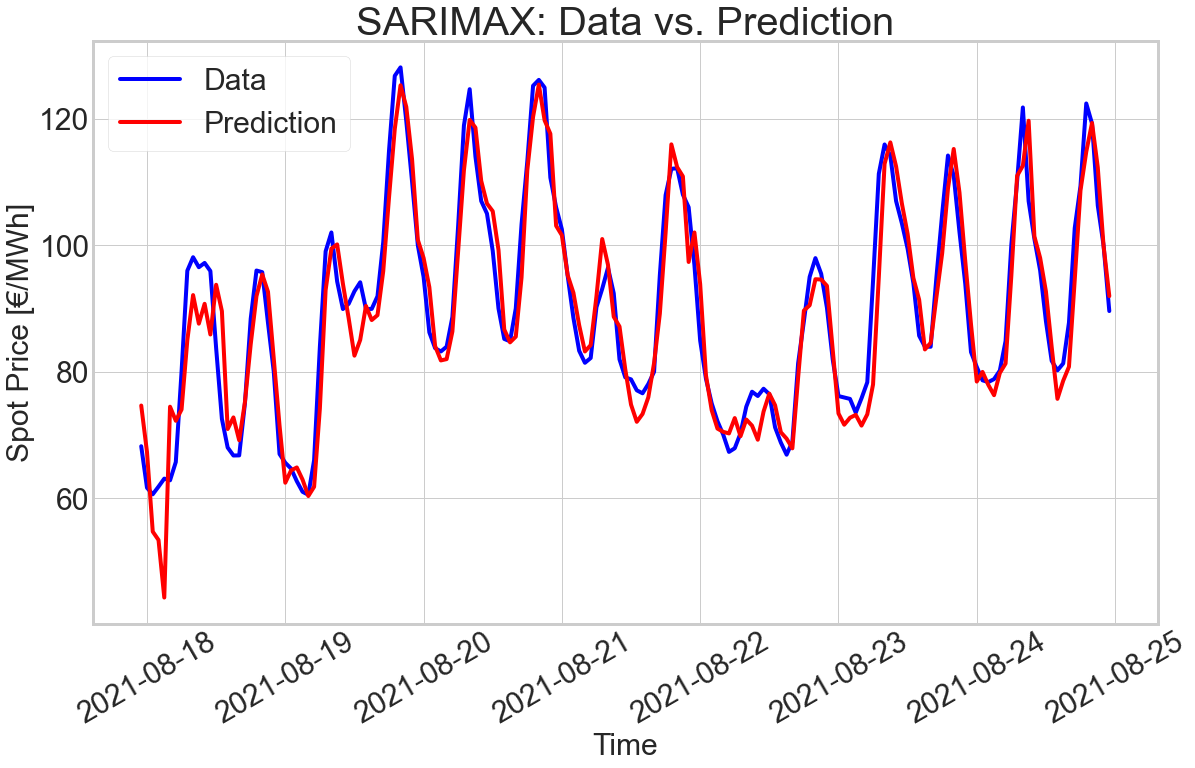

In [49]:
# rank_smape_1h (data until 24.08.2021)
plot_walk_forward_evaluation(pltdata_smape_1h, pred_smape_1h, wdw_smape_1h,0)

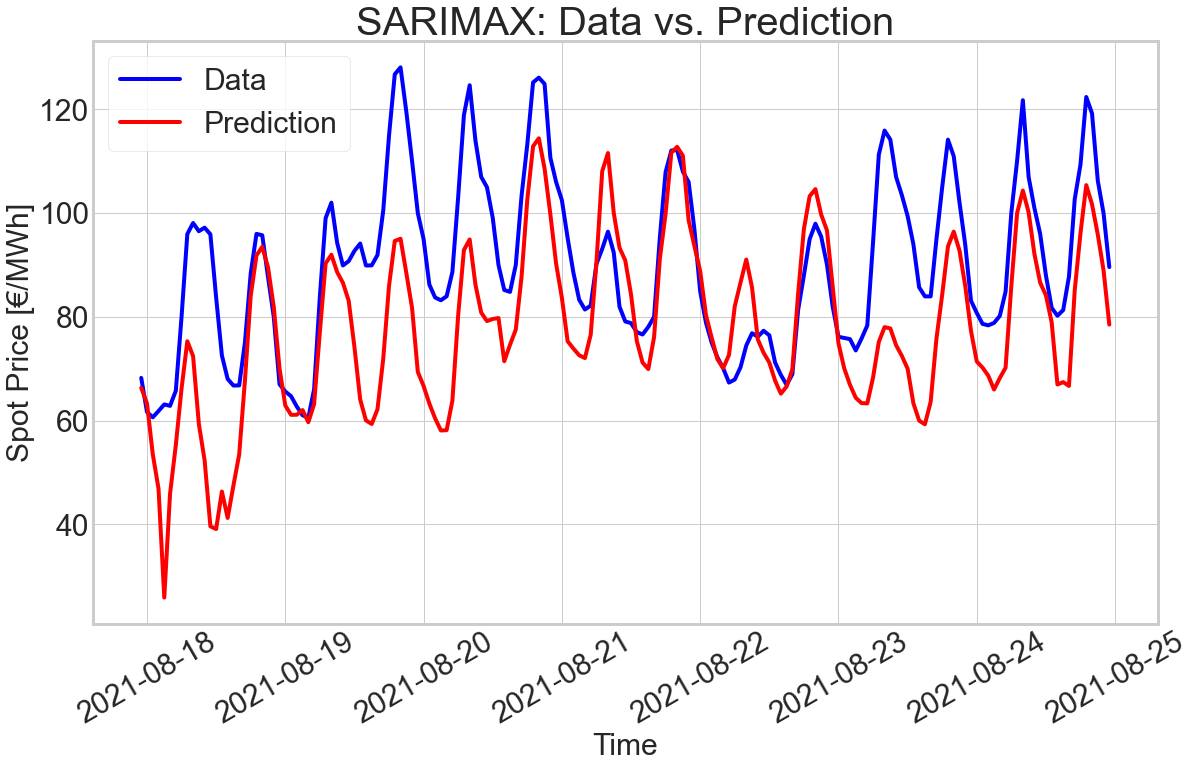

In [41]:
# rank_smape_24h (data until 24.08.2021)
plot_walk_forward_evaluation(pltdata_smape_24h,pred_smape_24h,wdw_smape_24h,23)

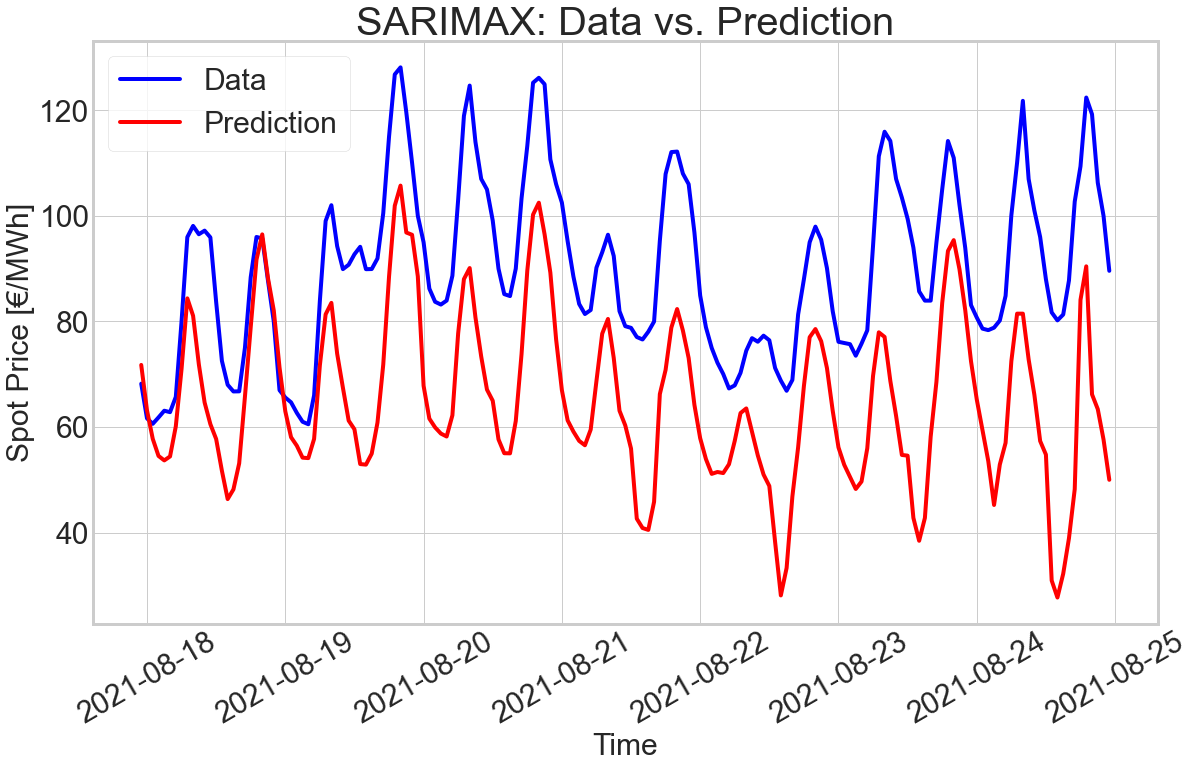

In [65]:
# rank_smape_168h (data until 24.08.2021)
plot_walk_forward_evaluation(pltdata_smape_168h,pred_smape_168h,wdw_smape_168h,167)

In [68]:
def plot_walk_forward_evaluation_score(data,pred,window,score, gap):
    """
    Plotting
    
    :param data: pandas series or dataframe of the spotprice data
    :param pred: numpy array with the prediction values from the evaluation
    :param window: window for sliding window evaluation
    :param score: list of evaluation score
    """
    
    plt.figure(figsize=[17,10])
    plt.plot(data[window+gap:], 'b', label='Data')
    plt.plot(data.index[window+gap:], pred, 'r', label='Prediction')
    plt.plot(data.index[window+gap:], score, 'c', label='Score')
    plt.tick_params(axis='x',labelsize=30)
    plt.tick_params(axis='y',labelsize=30)
    plt.xticks(rotation=30)
    plt.xlabel('Time', fontsize=30)
    plt.ylabel('Spot Price [€/MWh]', fontsize=30)
    plt.title('SARIMAX: Data vs. Prediction', fontsize=40)
    plt.legend(fontsize=30)

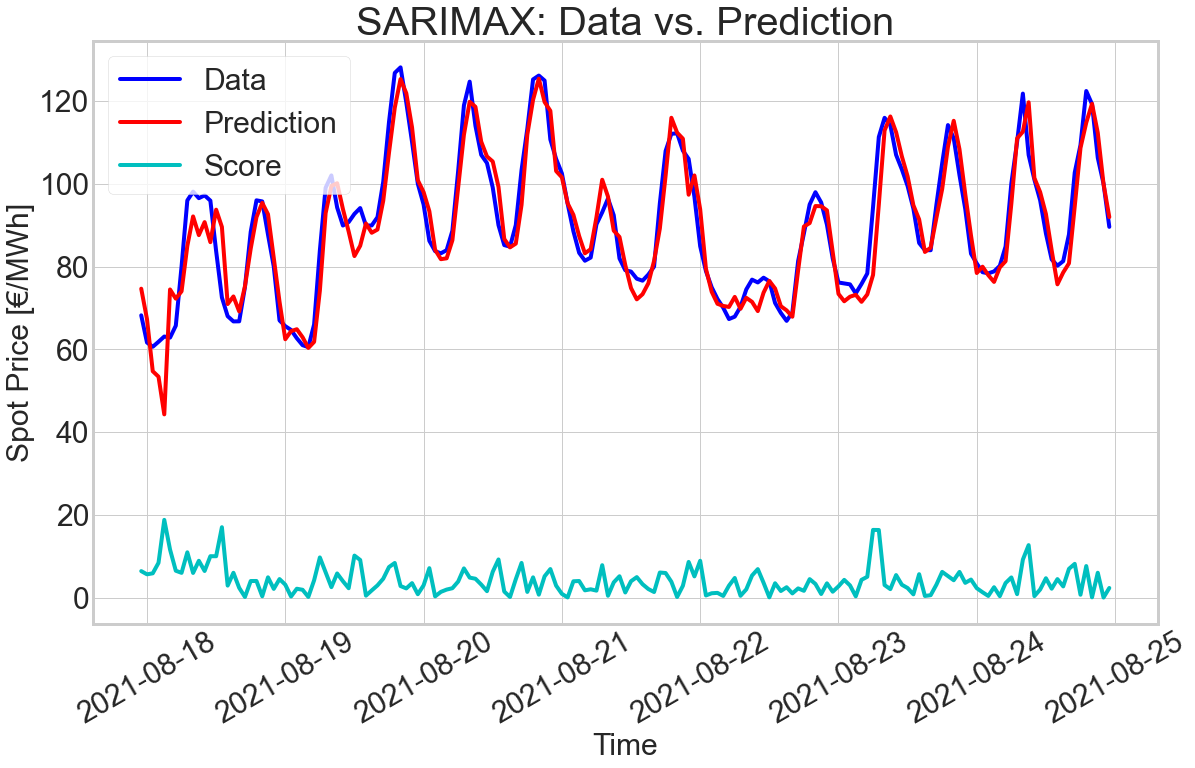

In [69]:
# rank_smape_1h (data until 24.08.2021)
plot_walk_forward_evaluation_score(pltdata_smape_1h, pred_smape_1h, wdw_smape_1h,sc_smape_1h,0)

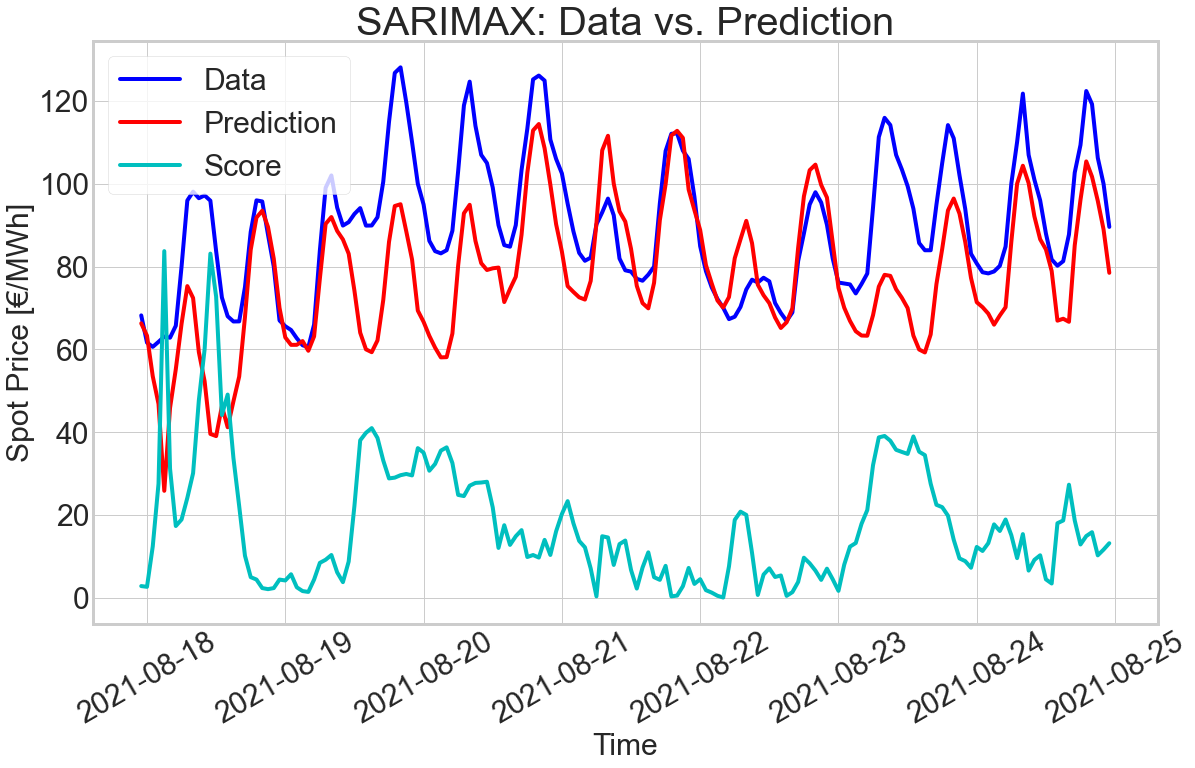

In [70]:
# rank_smape_24h (data until 24.08.2021)
plot_walk_forward_evaluation_score(pltdata_smape_24h,pred_smape_24h,wdw_smape_24h,sc_smape_24h,23)

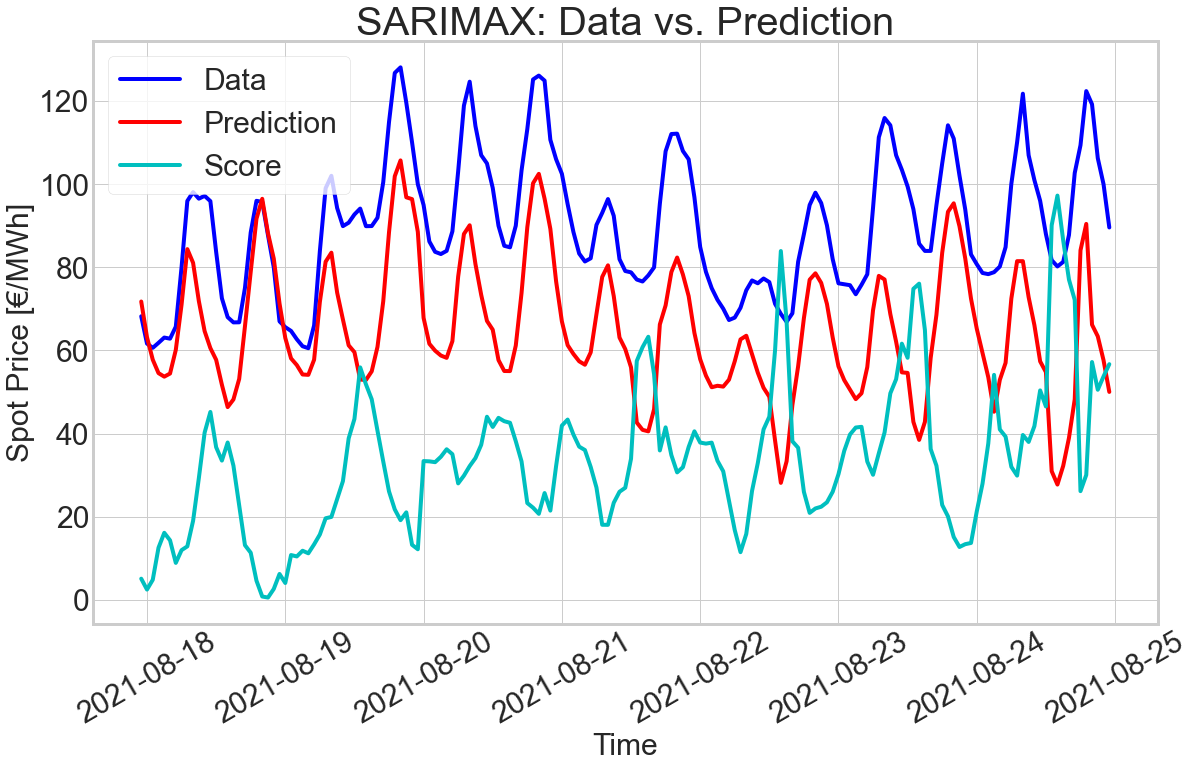

In [71]:
# rank_smape_168h (data until 24.08.2021)
plot_walk_forward_evaluation_score(pltdata_smape_168h,pred_smape_168h,wdw_smape_168h,sc_smape_168h,167)